# 0.0 IMPORTS

In [1]:
import pandas               as pd
import numpy                as np
import math


import seaborn              as sns
import scikitplot           as skplt

from sklearn.model_selection    import KFold
from matplotlib                 import pyplot as plt
from category_encoders          import TargetEncoder
from sklearn.model_selection    import StratifiedKFold
from xgboost                    import XGBClassifier as xgbc
from sklearn                    import preprocessing as pp
from sklearn                    import model_selection as ms
from sklearn                    import ensemble as en
from sklearn                    import neighbors as nh
from sklearn                    import linear_model as lm
from sklearn.preprocessing      import RobustScaler, MinMaxScaler, OneHotEncoder, StandardScaler

from scipy                      import stats as ss
from phik                       import phik_matrix
from IPython.display            import Image


## 0.1 Helper Functions

In [2]:
# CRAMER V

def cramer_v( x, y ):

    cm = pd.crosstab(x, y).values

    n = cm.sum()

    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))



# CREATE! One Hot Encoding Function

# # One Hot Enconding
# one_hot_vehicle_age = OneHotEncoder()

# vehicle_age_encoded = one_hot_vehicle_age.fit_transform(df5[['vehicle_age']])

# columns_created = one_hot_vehicle_age.get_feature_names_out()

# df5[columns_created] = vehicle_age_encoded.toarray()

# df5 = df5.drop(columns=['vehicle_age'])



# # Validation

# vehicle_age_encoded = one_hot_vehicle_age.transform(df_validation[['vehicle_age']])

# columns_created = one_hot_vehicle_age.get_feature_names_out()

# df_validation[columns_created] = vehicle_age_encoded.toarray()

# df_validation = df_validation.drop(columns=['vehicle_age'])

In [3]:
# Dark Theme charts
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#282828'
plt.rcParams['axes.facecolor'] = '#282828'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

# Charts Size Config
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 14

## 0.2 Loading Data

In [4]:
# Loading raw data
df_raw = pd.read_csv('../datasets/train.csv')
df_raw.head(2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0


| Coluna               | Descrição                                                                                     |
|----------------------|-----------------------------------------------------------------------------------------------|
| id                   | Unique ID for the customer                                                                   |
| Gender               | Gender of the customer                                                                       |
| Age                  | Age of the customer                                                                          |
| Driving_License      | 0: Customer does not have DL, 1: Customer already has DL                                      |
| Region_Code          | Unique code for the region of the customer                                                    |
| Previously_Insured   | 1: Customer already has Vehicle Insurance, 0: Customer doesn't have Vehicle Insurance         |
| Vehicle_Age          | Age of the Vehicle                                                                           |
| Vehicle_Damage       | 1: Customer got his/her vehicle damaged in the past. 0: Customer didn't get vehicle damaged  |
| Annual_Premium       | The amount customer needs to pay as premium in the year                                       |
| Policy_Sales_Channel | Anonymized Code for the channel of outreaching to the customer                                |
| Vintage              | Number of Days, Customer has been associated with the company                                 |
| Response             | 1: Customer is interested, 0: Customer is not interested                                     |


# 1.0 Data Description

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
df1 = df1.rename(columns=str.lower)

## 1.2 Data Dimension

In [7]:
# Data Dimension
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Cols: 12


## 1.3 Data Types

In [8]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [9]:
df1['policy_sales_channel'].unique()

array([ 26., 152., 160., 124.,  14.,  13.,  30., 156., 163., 157., 122.,
        19.,  22.,  15., 154.,  16.,  52., 155.,  11., 151., 125.,  25.,
        61.,   1.,  86.,  31., 150.,  23.,  60.,  21., 121.,   3., 139.,
        12.,  29.,  55.,   7.,  47., 127., 153.,  78., 158.,  89.,  32.,
         8.,  10., 120.,  65.,   4.,  42.,  83., 136.,  24.,  18.,  56.,
        48., 106.,  54.,  93., 116.,  91.,  45.,   9., 145., 147.,  44.,
       109.,  37., 140., 107., 128., 131., 114., 118., 159., 119., 105.,
       135.,  62., 138., 129.,  88.,  92., 111., 113.,  73.,  36.,  28.,
        35.,  59.,  53., 148., 133., 108.,  64.,  39.,  94., 132.,  46.,
        81., 103.,  90.,  51.,  27., 146.,  63.,  96.,  40.,  66., 100.,
        95., 123.,  98.,  75.,  69., 130., 134.,  49.,  97.,  38.,  17.,
       110.,  80.,  71., 117.,  58.,  20.,  76., 104.,  87.,  84., 137.,
       126.,  68.,  67., 101., 115.,  57.,  82.,  79., 112.,  99.,  70.,
         2.,  34.,  33.,  74., 102., 149.,  43.,   

## 1.4 Check NaN

In [10]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## ~~1.5 Fillout NaN~~

## 1.6 Change Types

In [11]:
df1['region_code'] = df1['region_code'].astype(int)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)

df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code               int32
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel      int32
vintage                   int64
response                  int64
dtype: object

## 1.7 Descriptive Statical

In [12]:
# Separete vars 

num_attributes = df1.select_dtypes(include=['int','float'])
cat_attributes = df1.select_dtypes(exclude=['int','float'])

### 1.7.1 Numerical Attributes

In [13]:
# Central Tendency (ct) - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std) ).T
d2 = pd.DataFrame(num_attributes.apply(min) ).T
d3 = pd.DataFrame(num_attributes.apply(max) ).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min()) ).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew()) ).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()) ).T

#Concatenate - save in "m" metrics

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


C:\Users\andre\AppData\Local\Temp\ipykernel_10908\2681509026.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['response'])


<Axes: xlabel='response', ylabel='Density'>

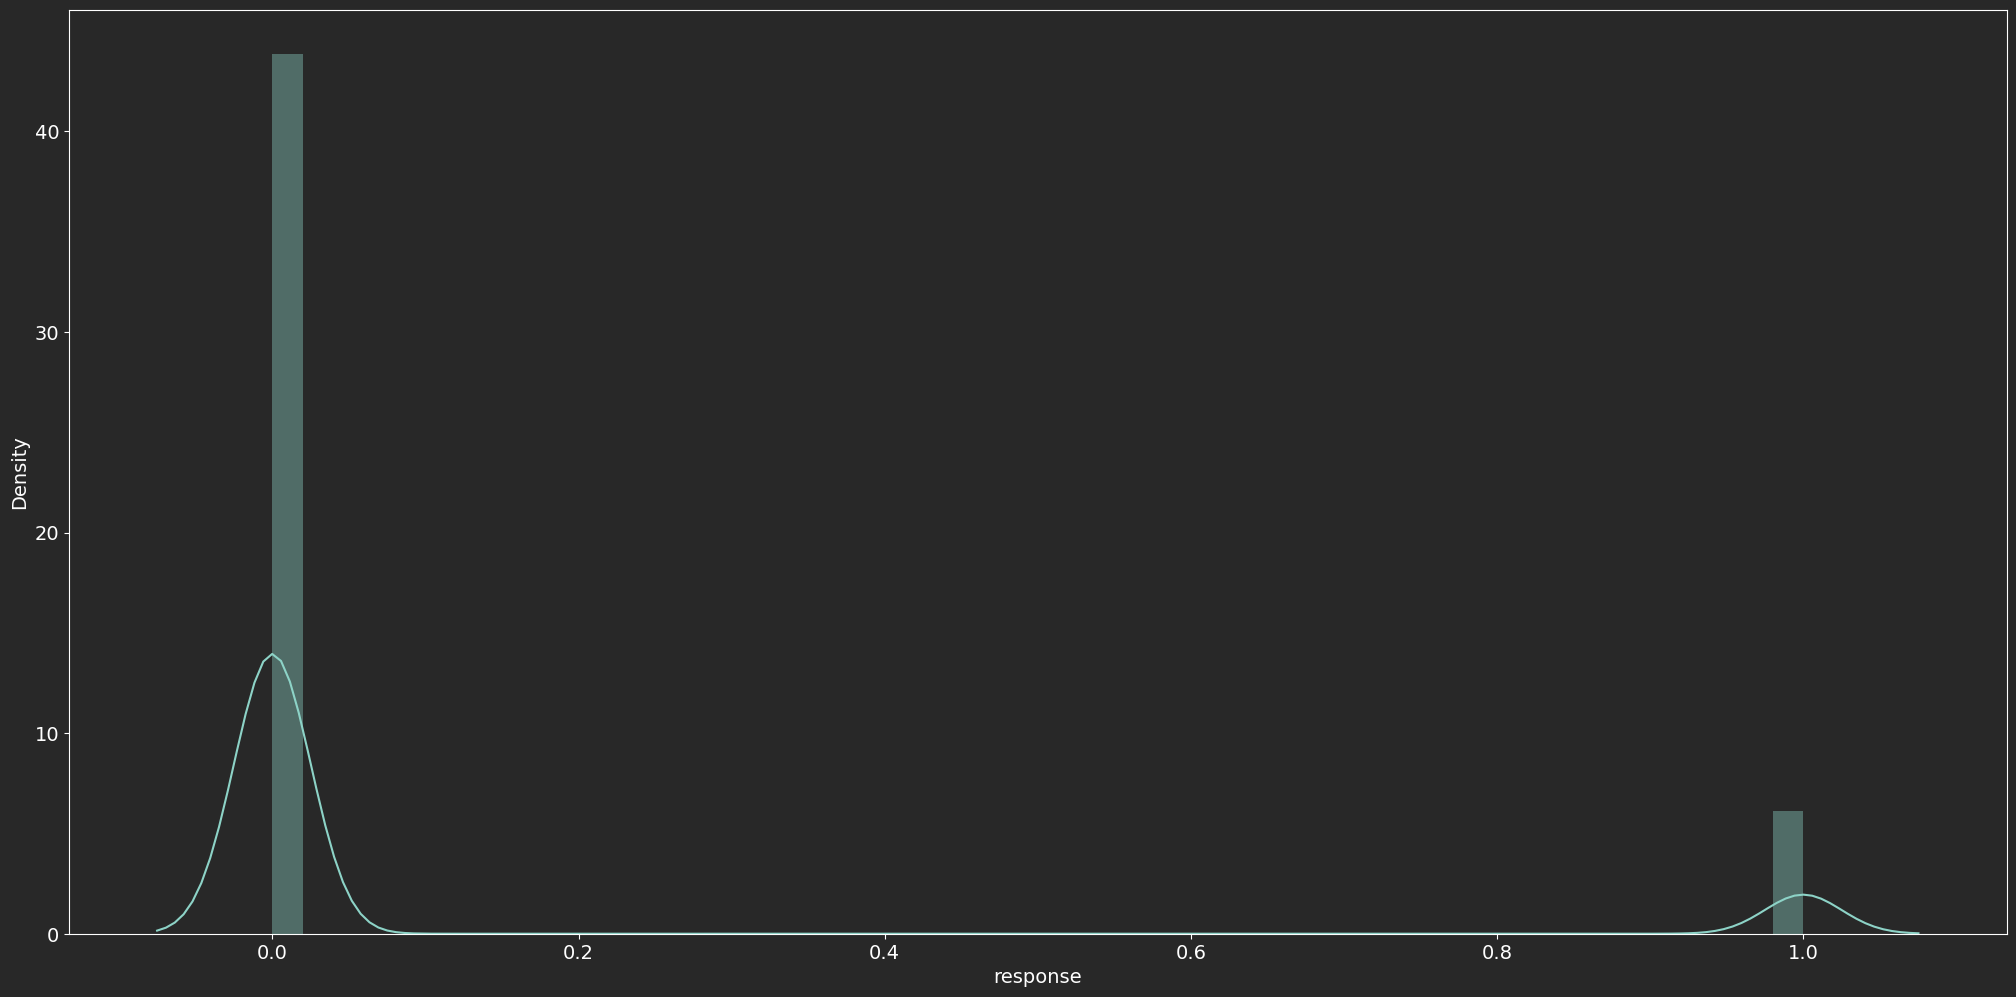

In [14]:
sns.distplot(df1['response'])

### 1.7.2 Categorical Attributes

In [15]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

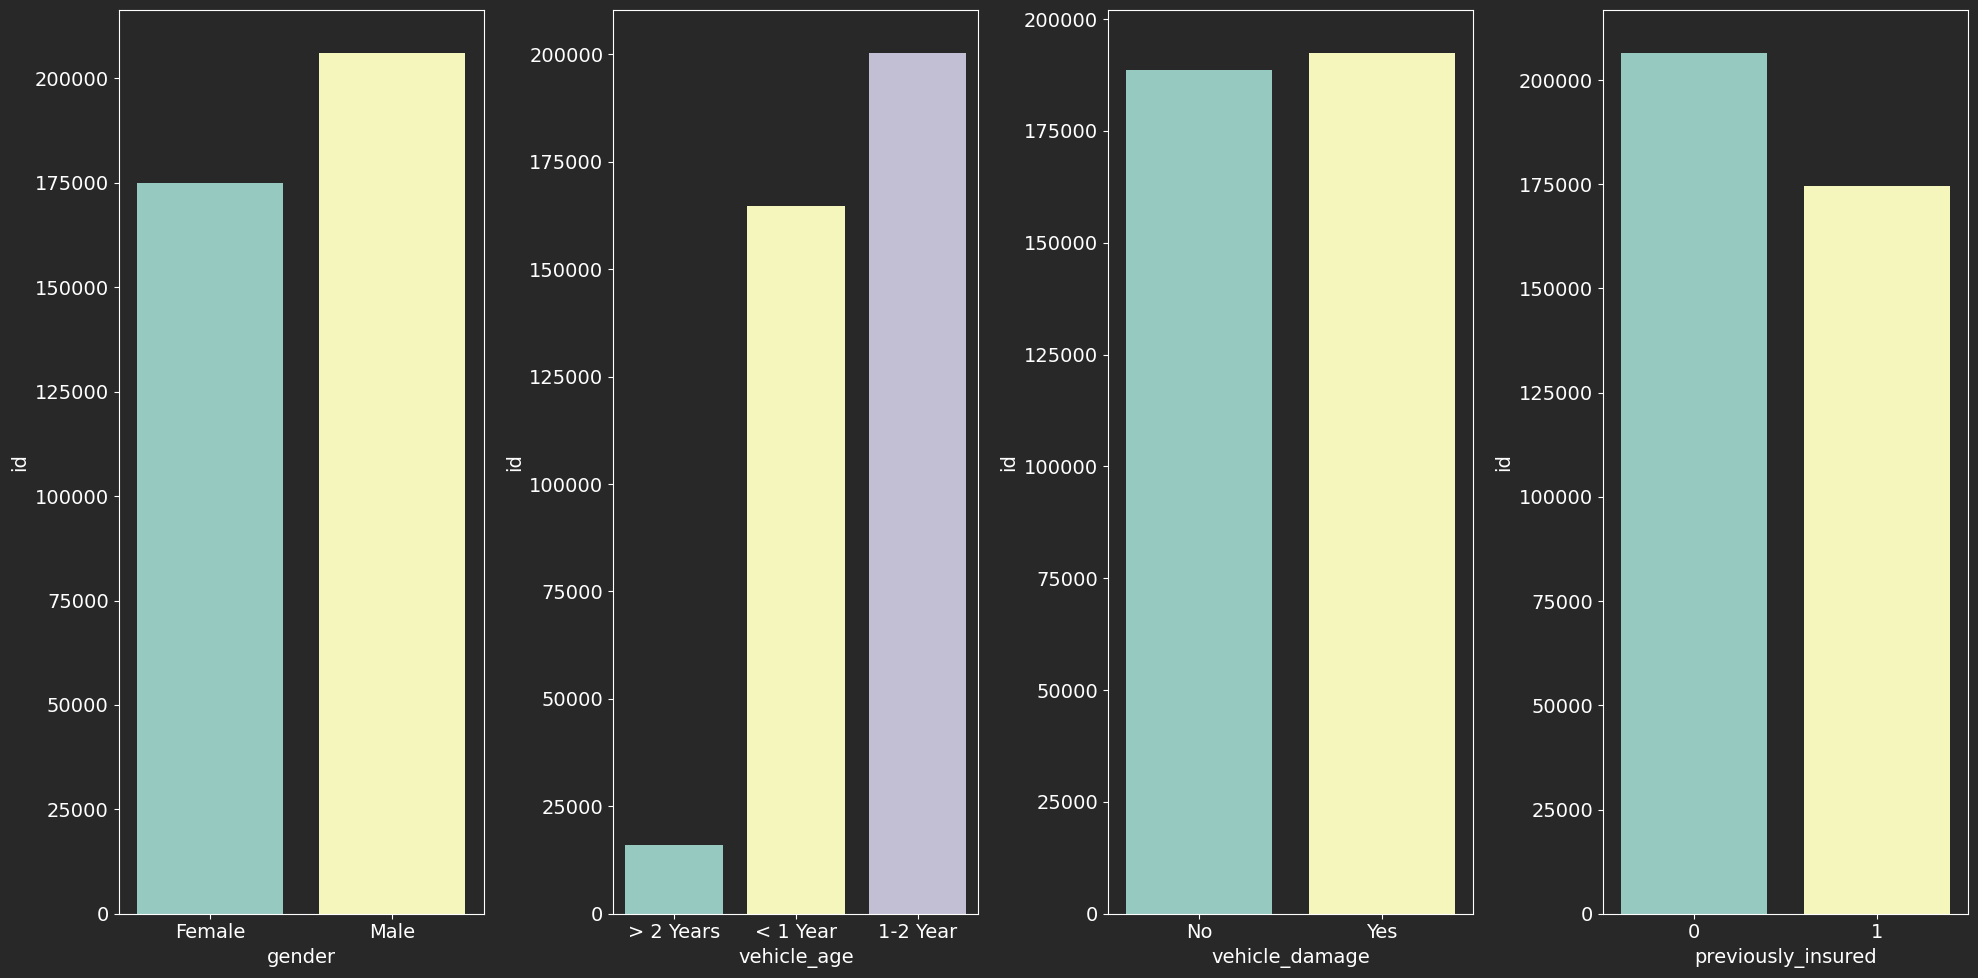

In [16]:
# Charts about categorical attributes 

aux1 = df1.loc[:, ['gender', 'id']].groupby('gender').count().sort_values('id', ascending=True).reset_index()
aux1

aux2 = df1.loc[:, ['vehicle_age', 'id']].groupby('vehicle_age').count().sort_values('id', ascending=True).reset_index()
aux2

aux3 = df1.loc[:, ['vehicle_damage', 'id']].groupby('vehicle_damage').count().sort_values('id', ascending=True).reset_index()
aux3

aux4 = df1.loc[:, ['previously_insured', 'id']].groupby('previously_insured').count().sort_values('id', ascending=True).reset_index()
aux4 # 1: Customer already has Vehicle Insurance, 0: Customer doesn't have Vehicle Insurance


# plt.subplot(1,4,1)
# sns.barplot(data=aux1, x='gender', y='id')
# plt.subplot(1,4,2)
# sns.barplot(data=aux2, x='vehicle_age', y='id')
# plt.subplot(1,4,3)
# sns.barplot(data=aux3, x='vehicle_damage', y='id')
# plt.subplot(1,4,4)
# sns.barplot(data=aux4, x='previously_insured', y='id')


fig, axs = plt.subplots(1, 4, figsize=(20, 10))

sns.barplot(data=aux1, x='gender', y='id', ax=axs[0])
sns.barplot(data=aux2, x='vehicle_age', y='id', ax=axs[1])
sns.barplot(data=aux3, x='vehicle_damage', y='id', ax=axs[2])
sns.barplot(data=aux4, x='previously_insured', y='id', ax=axs[3])

plt.tight_layout()

# 2.0 Feature Engineering

## 2.1 MindMap Hypotheses

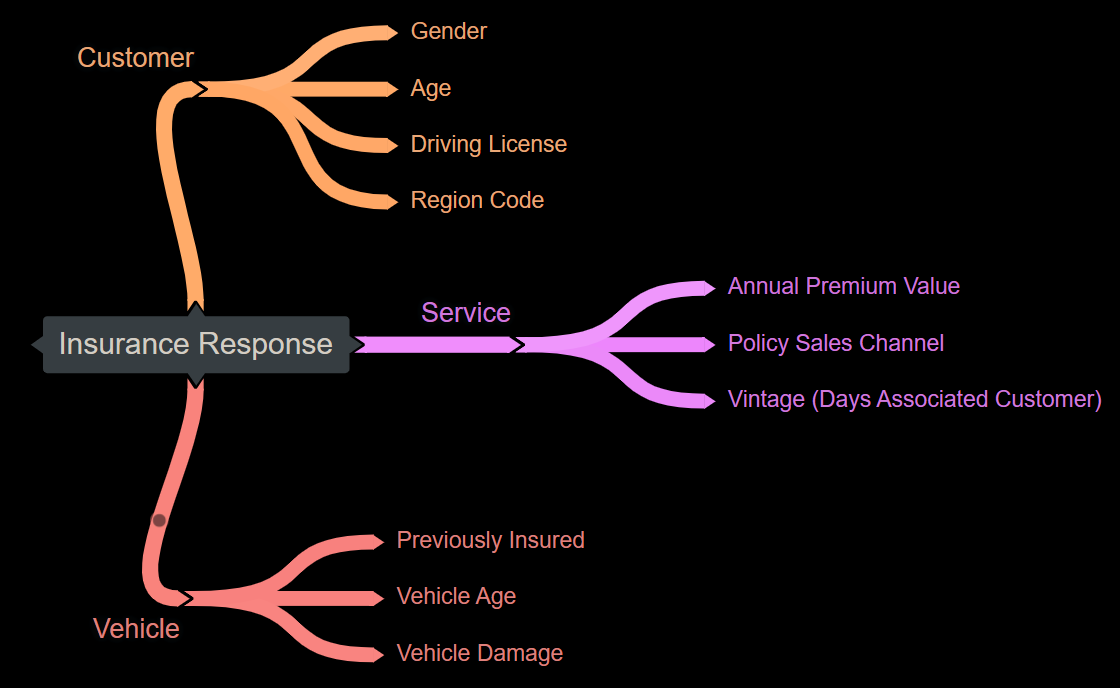

In [17]:
Image('../images/mindmap_insurance.PNG')

## 2.2 Hypoteses Creation

In [18]:
df2 = df1.copy()

### 2.2.1 Hypoteses Customer

**1.** Clientes com maior idade possuem mais interesse no seguro.

**2.** Clientes masculinos possuem mais interesse no seguro.

**3.** Clientes com licença para dirigir possuem mais interesse no seguro.

**4.** Clientes da região 8 possuem mais interesse no seguro.

### 2.2.2 Hypoteses Vehicle

**1.** Clientes com o veículo já assegurado não possuem interesse no seguro.

**2.** Veículos mais novos possuem mais interesse no seguro.

**3.** Veículos já danificados possuem menos interesse no seguro.

### 2.2.3 Hypoteses Service

**1.** Valores menores de seguro interessam mais os clientes.

**2.** Os canais de vendas 122 e 160 possuem mais retorno positivo para o seguro.

**3.** Clientes a mais tempo assegurados possuem mais interesse no seguro de carro.

## 2.3 Final List of Hypoteses

**1.** Clientes com maior idade possuem mais interesse no seguro.

**2.** Clientes masculinos possuem mais interesse no seguro.

**3.** Clientes com licença para dirigir possuem mais interesse no seguro.

**4.** Clientes da região 8 possuem mais interesse no seguro.

**5.** Clientes com o veículo já assegurado não possuem interesse no seguro.

**6.** Veículos mais novos possuem mais interesse no seguro.

**7.** Veículos já danificados possuem menos interesse no seguro.

**8.** Valores menores de seguro interessam mais os clientes.

**9.** Os canais de vendas 122 e 160 possuem mais retorno positivo para o seguro.

**10.** Clientes a mais tempo assegurados possuem mais interesse no seguro de carro.

## ~~2.4 Feature Engineering~~

# 3.0 Variable Filtering

In [19]:
df3 = df2.copy()

## ~~3.1 Rows Filtering~~

## ~~3.2 Columns Select~~

# 4.0 Exploratory Data Analysis

In [20]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

C:\Users\andre\AppData\Local\Temp\ipykernel_10908\3518556581.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['response']);


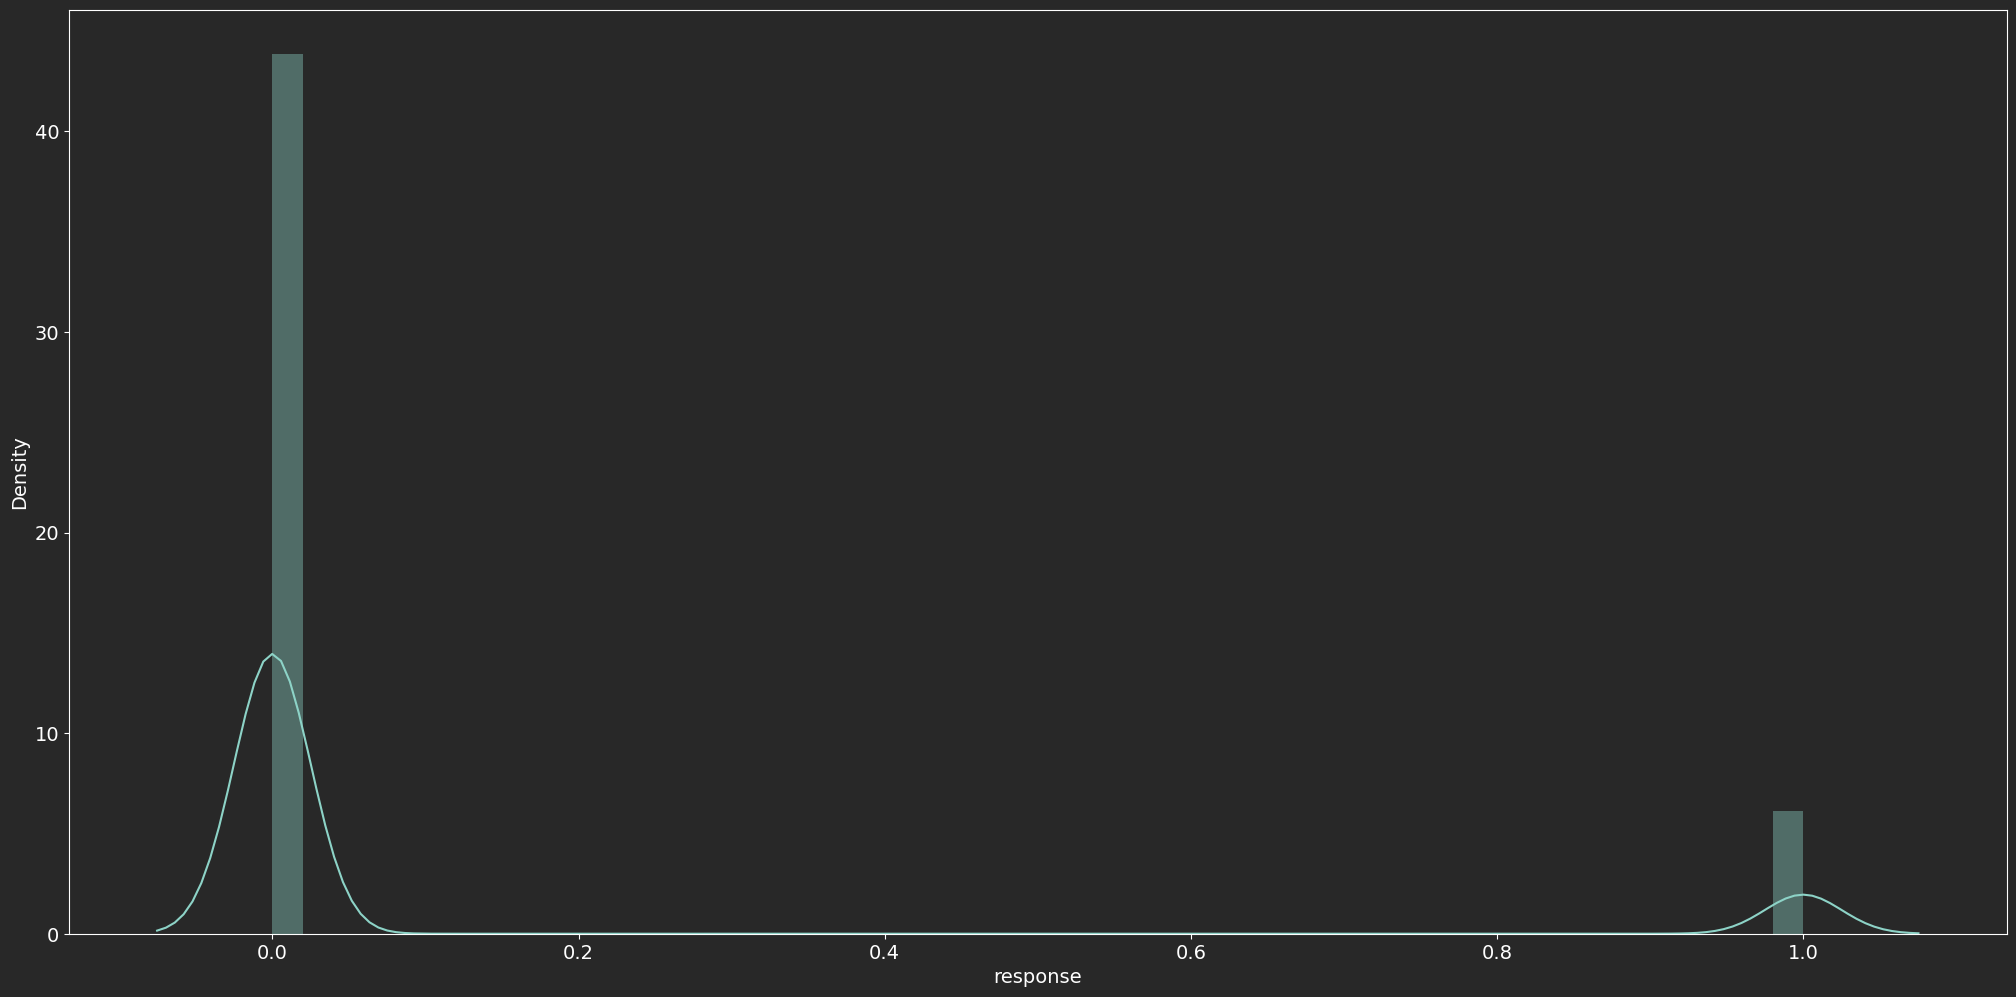

In [21]:
sns.distplot(df4['response']);

### 4.1.2 Numerical Variable

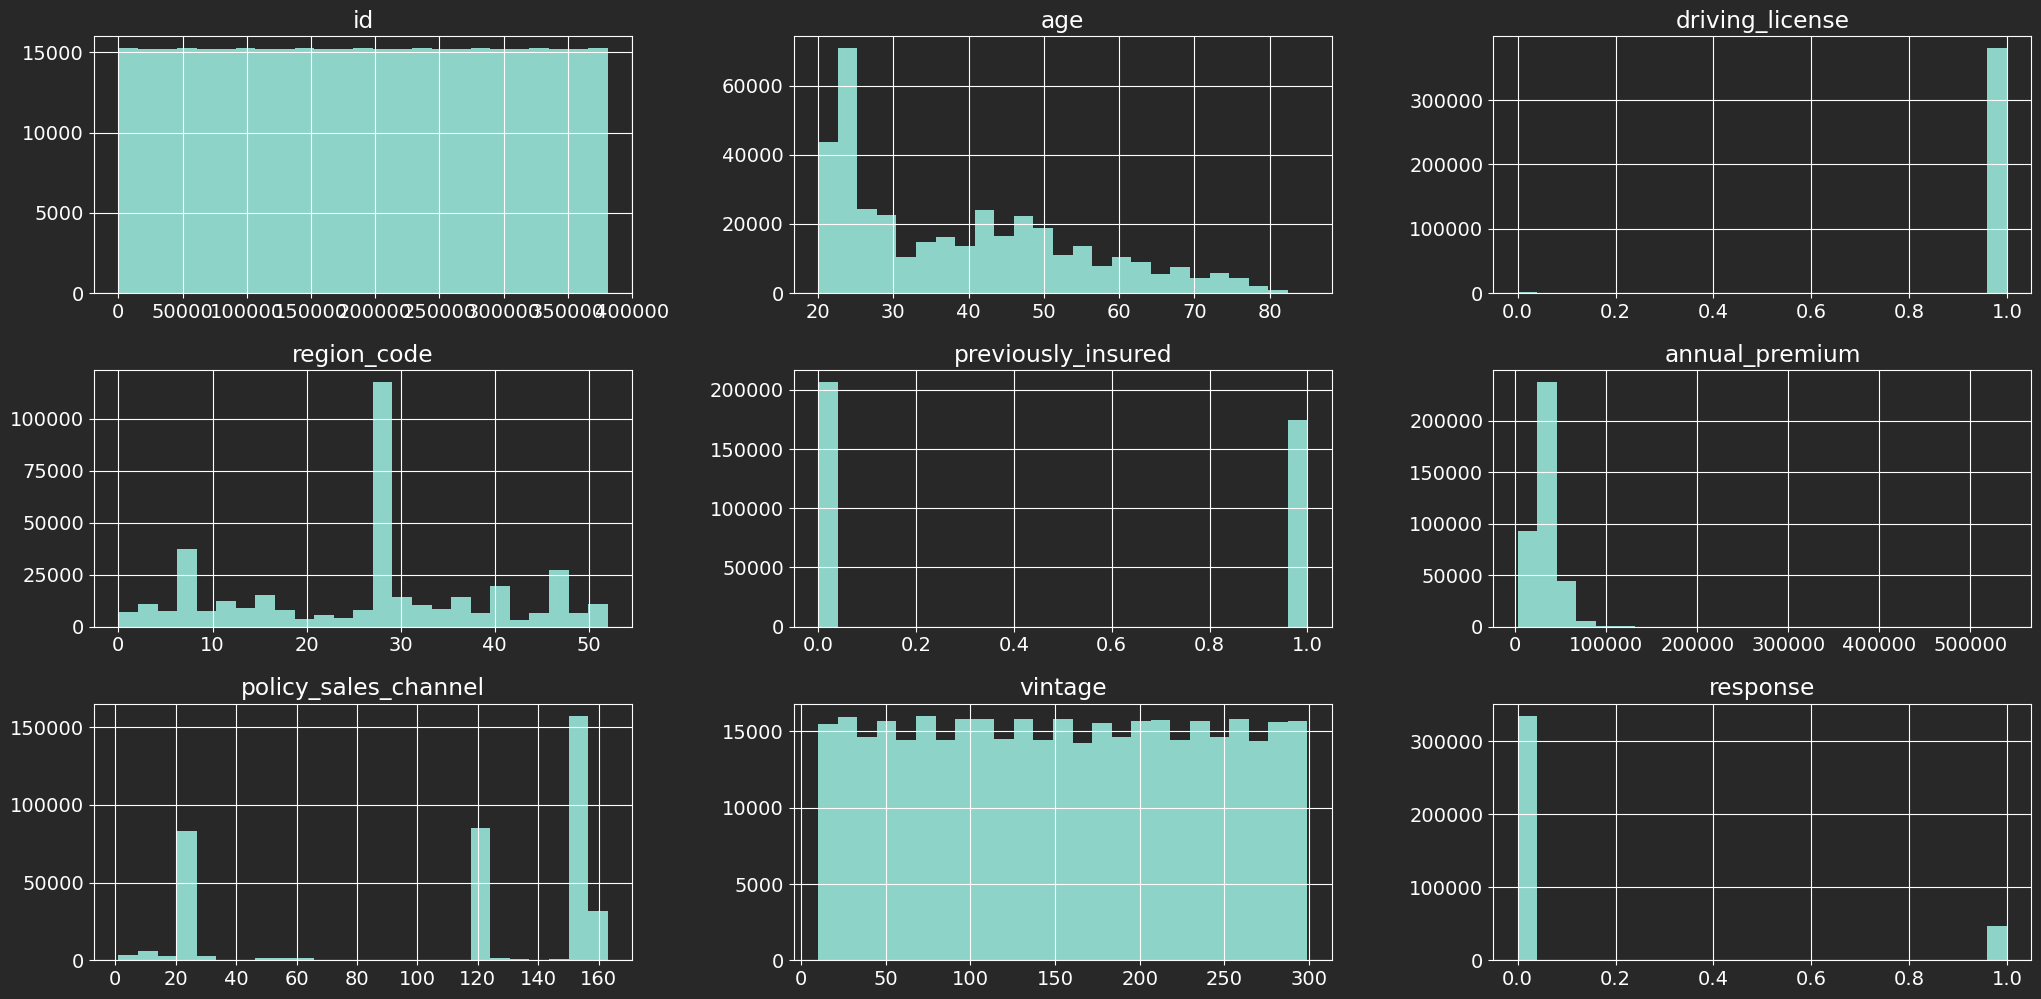

In [22]:
num_attributes.hist(bins=25);

# O eixo horizontal representa os intervalos dos valores e o eixo vertical representa a contagem de ocorrências.

### 4.1.3 Categorical Variable

In [23]:
df4['gender'].drop_duplicates()
df4['vehicle_age'].drop_duplicates()
# df4['vehicle_damage'].drop_duplicates()

0    > 2 Years
1     1-2 Year
3     < 1 Year
Name: vehicle_age, dtype: object

C:\Users\andre\AppData\Local\Temp\ipykernel_10908\680826365.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, 1)
C:\Users\andre\AppData\Local\Temp\ipykernel_10908\680826365.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, 2)


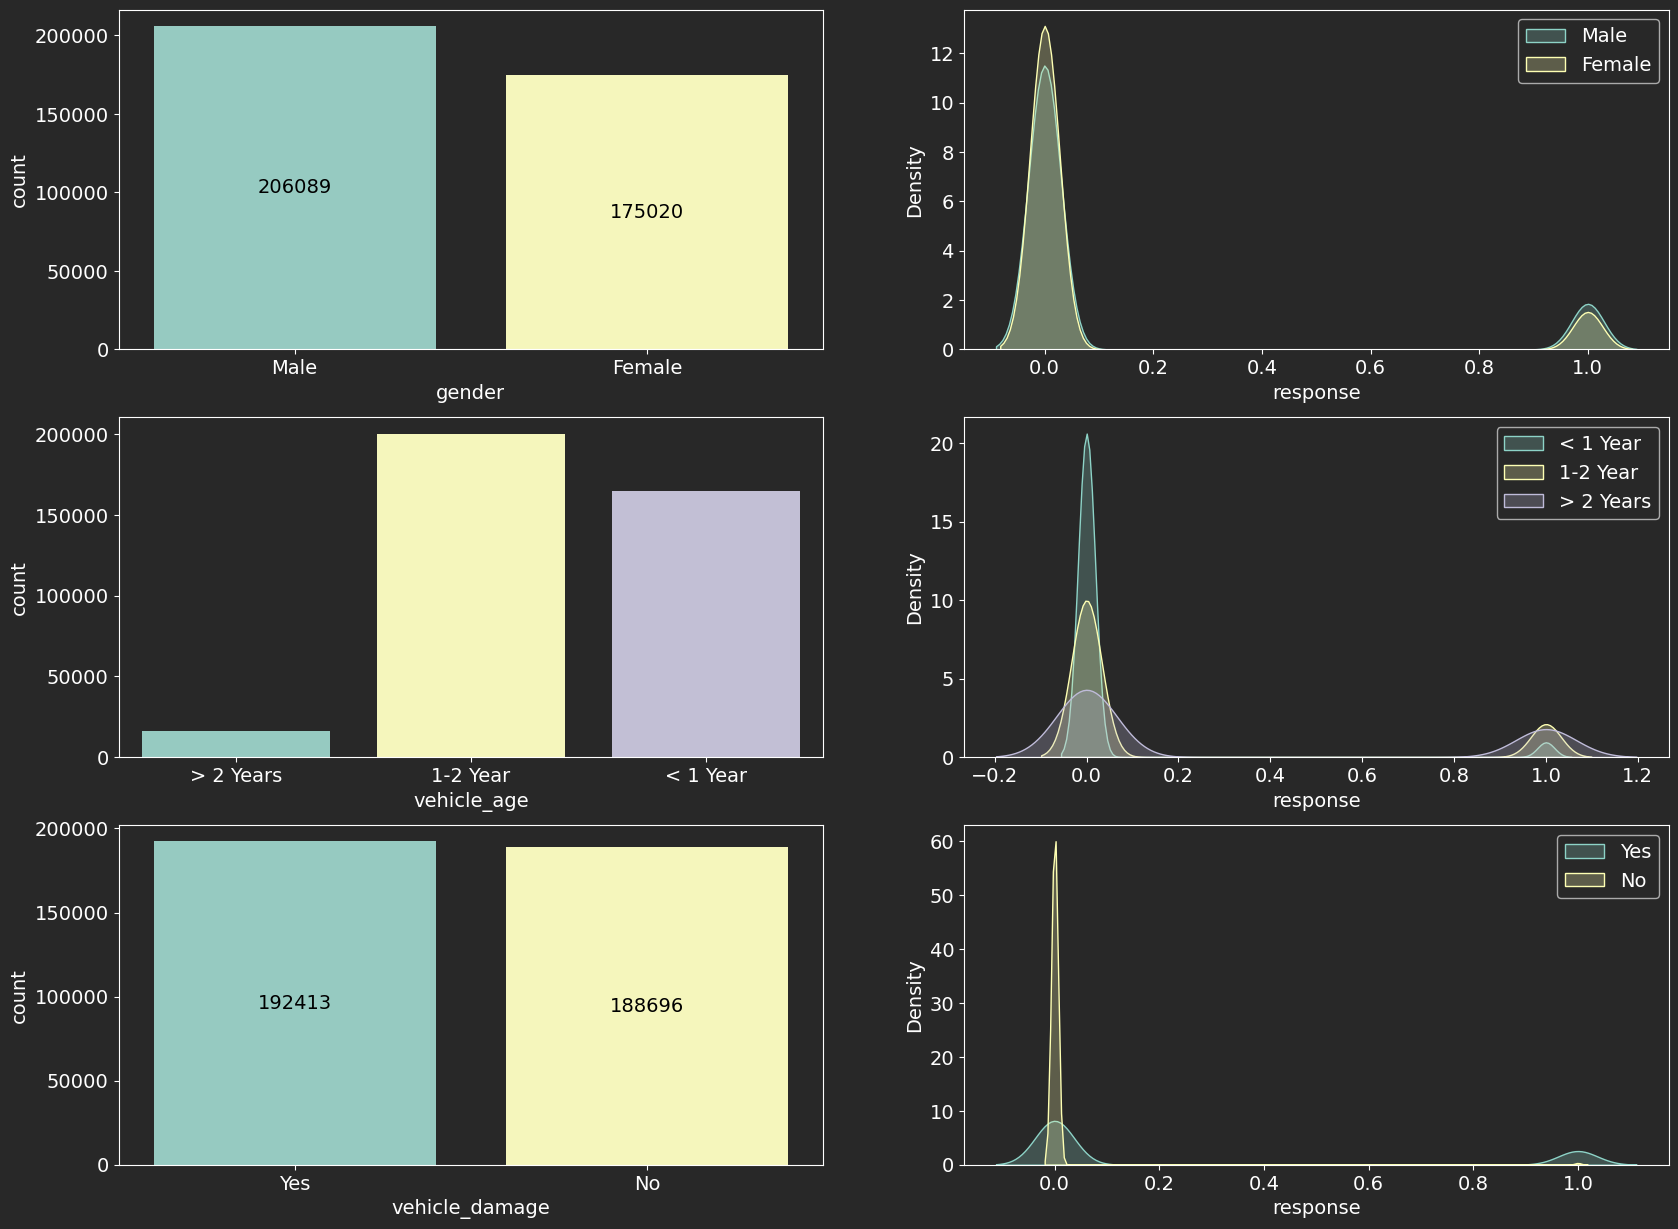

In [24]:
fig, axs = plt.subplots(1, 4, figsize=(20, 15))

# Gender var
plt.subplot(3, 2, 1)
ax1 = sns.countplot(x = df4['gender'])
ax1.bar_label(ax1.containers[0], label_type='center', fontsize=14, color='black')

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['gender'] == 'Male']['response'], label = 'Male', fill = True)
sns.kdeplot(df4[df4['gender'] == 'Female']['response'], label = 'Female', fill = True)
plt.legend()


# Vehicle_age var
plt.subplot(3, 2, 3)
sns.countplot(x = df4['vehicle_age'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['vehicle_age'] == '< 1 Year']['response'], label = '< 1 Year', fill = True)
sns.kdeplot(df4[df4['vehicle_age'] == '1-2 Year']['response'], label = '1-2 Year', fill = True)
sns.kdeplot(df4[df4['vehicle_age'] == '> 2 Years']['response'], label = '> 2 Years', fill = True)
plt.legend()


# Vehicle_damage var 
plt.subplot(3, 2, 5)
ax2 = sns.countplot(x = df4['vehicle_damage'])
ax2.bar_label(ax2.containers[0], label_type='center', fontsize=14, color='black')

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['vehicle_damage'] == 'Yes']['response'], label = 'Yes', fill = True)
sns.kdeplot(df4[df4['vehicle_damage'] == 'No']['response'], label = 'No', fill = True)
plt.legend()


## 4.2 Bivariate Analysis

### **H1.** Clientes com maior idade possuem mais interesse no seguro.
**False** - Clientes entre 36 a 45 anos de idade possuem mais interesse no seguro.

<Axes: >

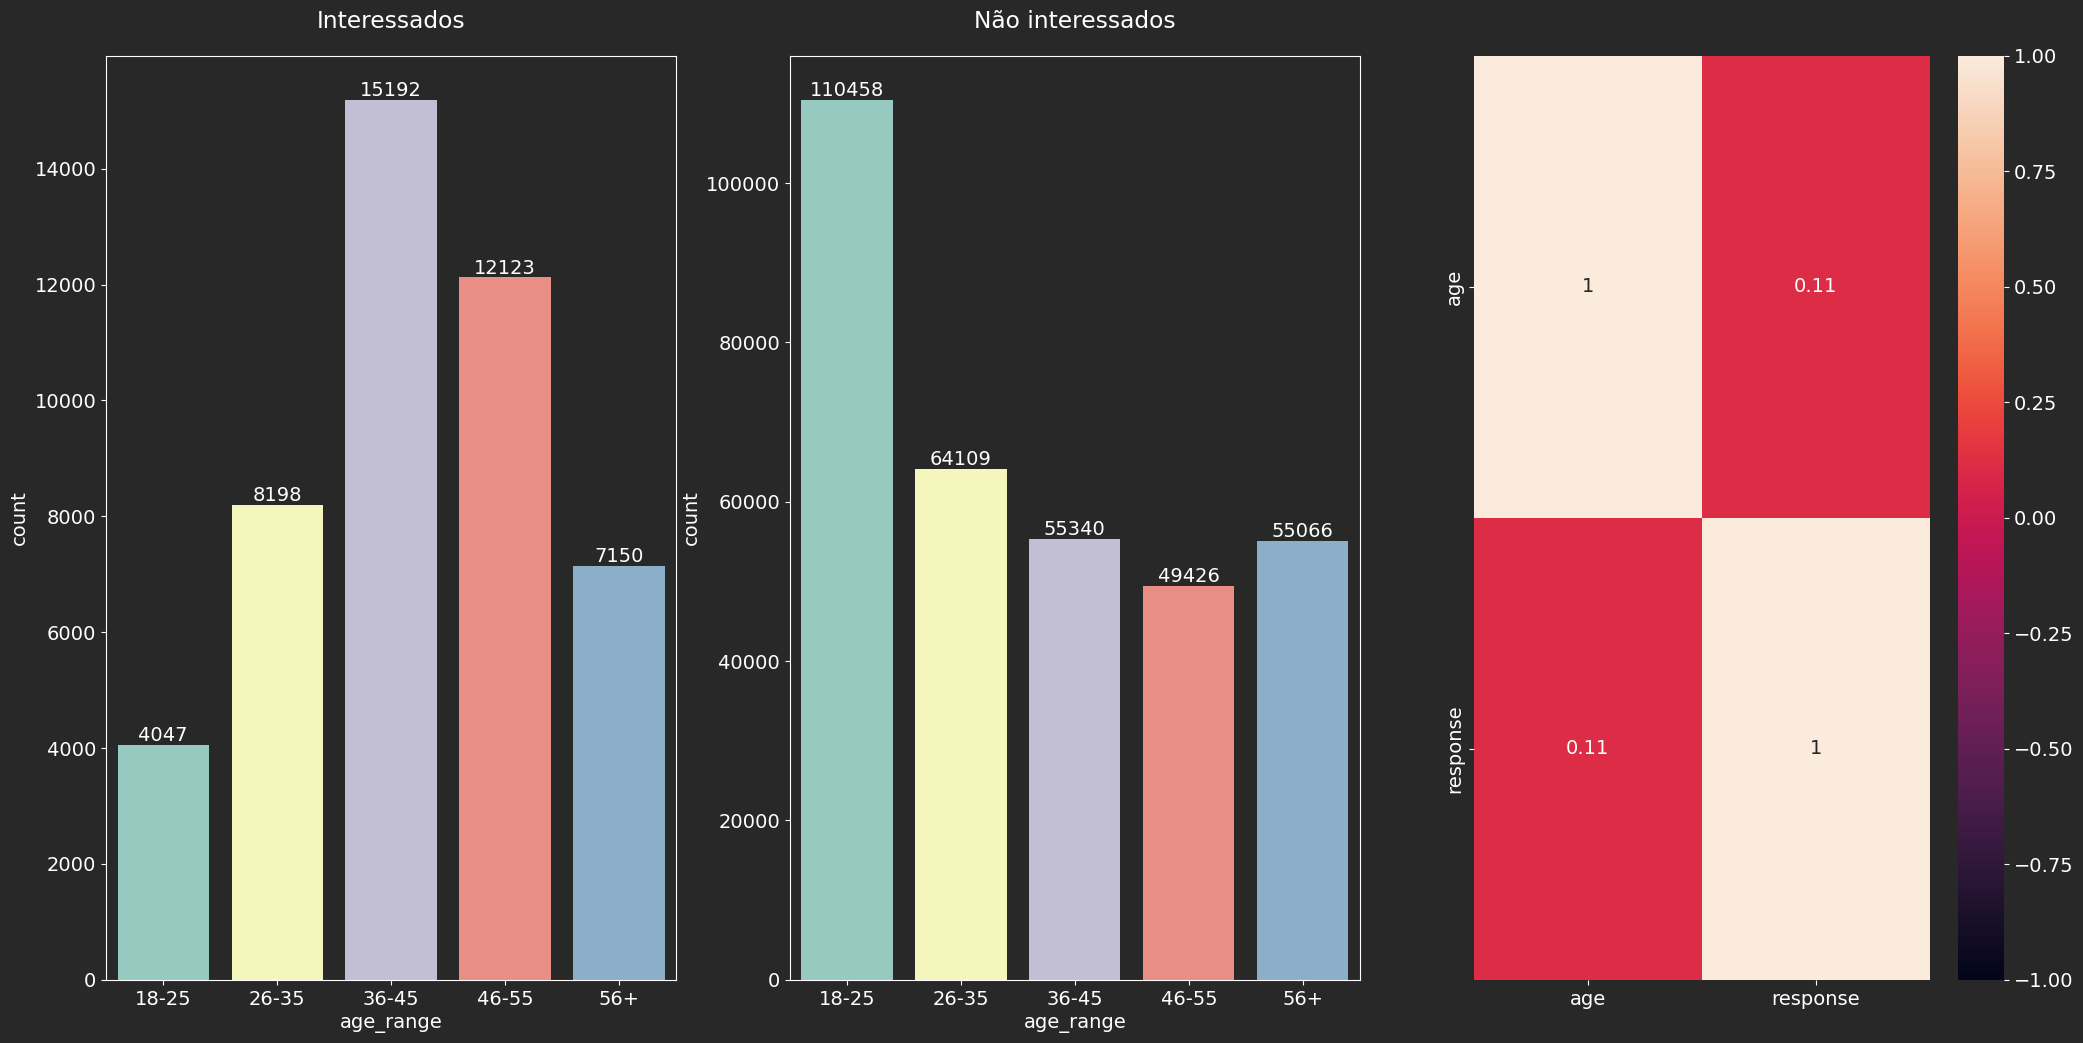

In [25]:
# Creating age ranges
aux_age = df4.copy()
range = [18, 26, 36, 46, 56, 200]
labels = ['18-25', '26-35', '36-45', '46-55', '56+']
aux_age['age_range'] = pd.cut(aux_age['age'], bins=range, labels=labels, right=False)


# Charts
plt.subplot(1, 3, 1)
aux_age1 = aux_age[aux_age['response'] == 1]
ax1 = sns.countplot(data=aux_age1, x=aux_age1['age_range'])
ax1.bar_label(ax1.containers[0], label_type='edge', fontsize=14, color='white')
plt.title('Interessados', pad=20)

plt.subplot(1, 3, 2)
aux_age2 = aux_age[aux_age['response'] == 0]
ax2 = sns.countplot(data=aux_age2, x=aux_age2['age_range'])
ax2.bar_label(ax2.containers[0], label_type='edge', fontsize=14, color='white')
plt.title('Não interessados', pad=20)


# Correlation
plt.subplot(1, 3, 3)
age_corr = aux_age[['age', 'response']]
sns.heatmap(age_corr.corr(method='pearson'), annot=True, vmin=-1, vmax=1)

# Correlation found 0.11: Weak positive correlation.

### **H2.** Clientes masculinos possuem mais interesse no seguro.
**True** - Clientes masculinos possuem MAIS interesse no seguro.

<Axes: >

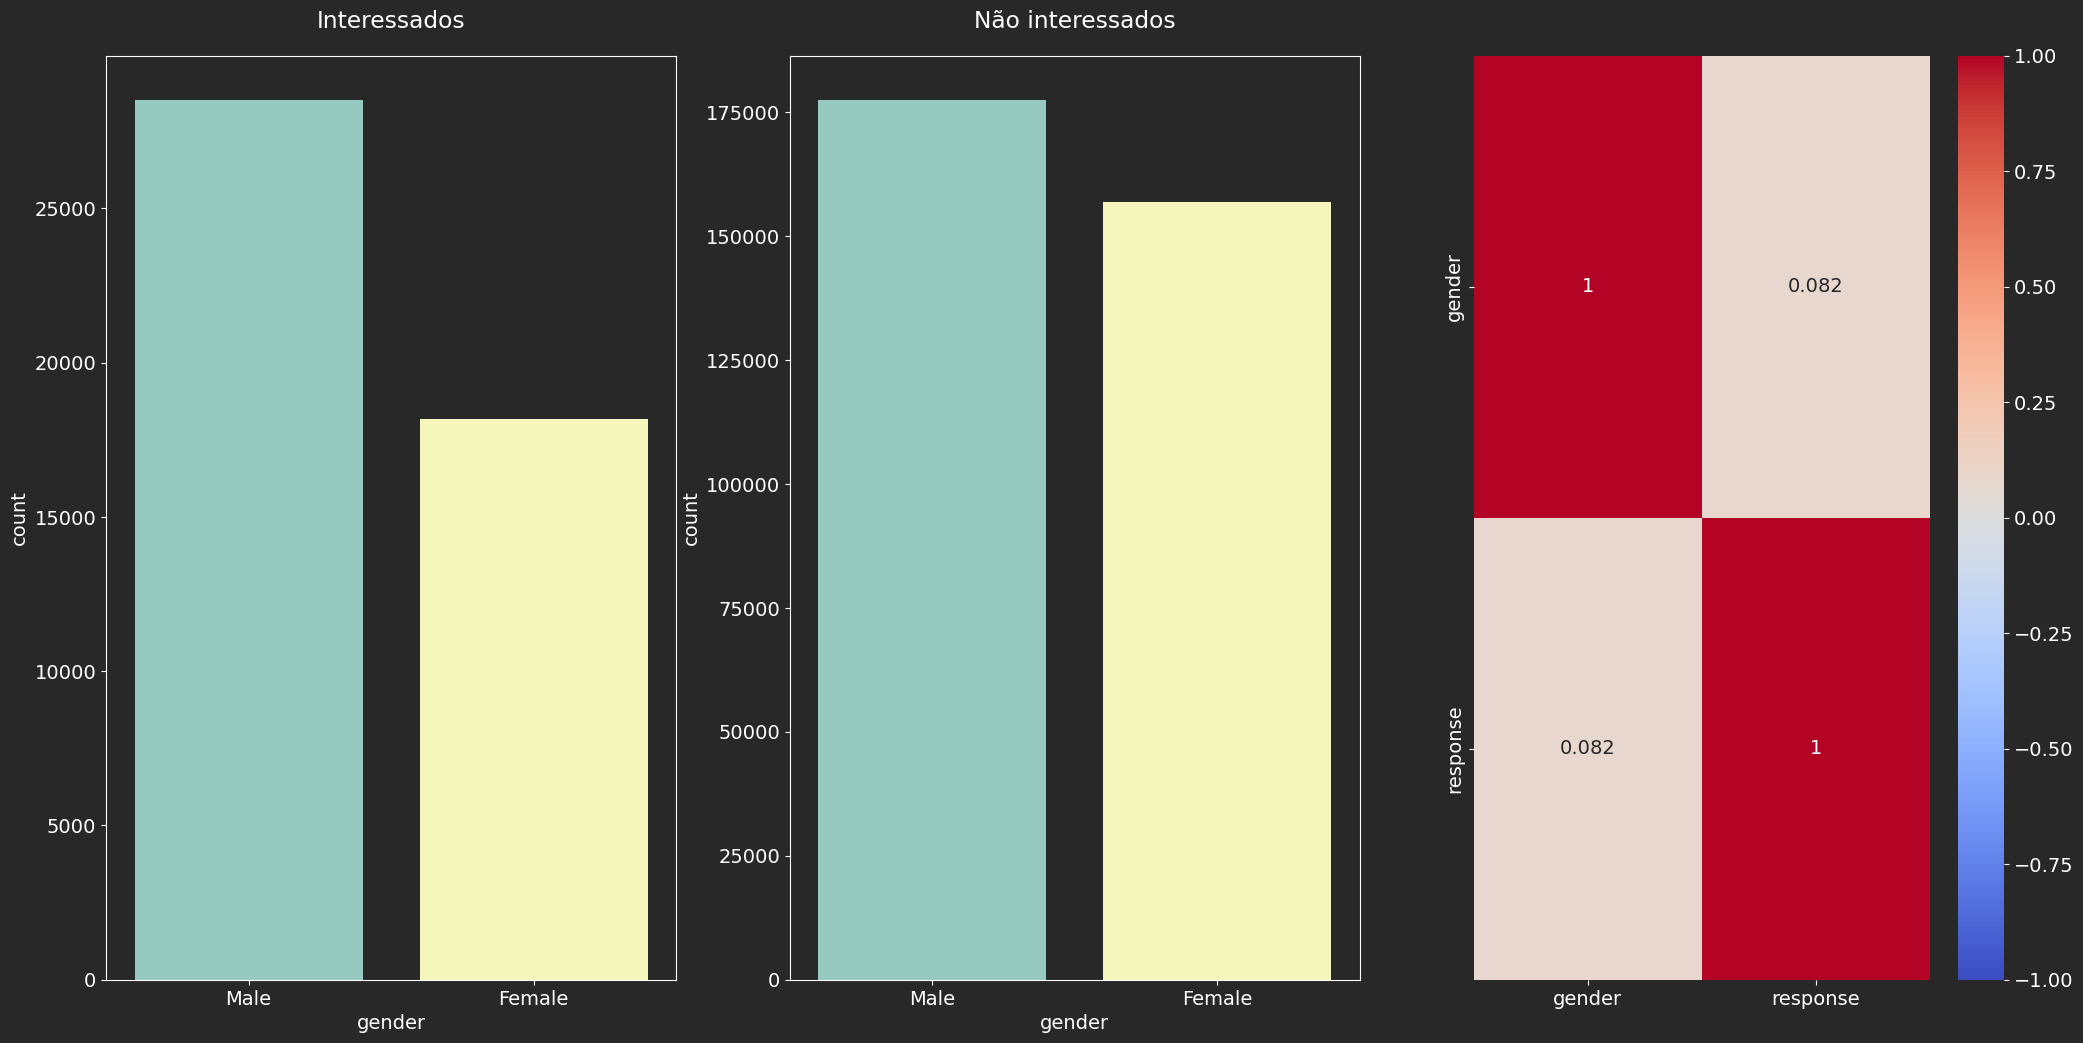

In [26]:
aux_male_1 = df4[df4['response'] == 1]
plt.subplot(1, 3, 1)
sns.countplot(data=aux_male_1, x=aux_male_1['gender'])
plt.title('Interessados', pad=20)


aux_male_0 = df4[df4['response'] == 0]
plt.subplot(1, 3, 2)
sns.countplot(data=aux_male_0, x=aux_male_0['gender'])
plt.title('Não interessados', pad=20)


gender_corr = df4[['gender', 'response']].copy()
gender_corr['gender'] = gender_corr['gender'].apply(lambda x: 1 if x == 'Male' else 0)
plt.subplot(1, 3, 3)
phi_matrix = phik_matrix(gender_corr, interval_cols=['response'])
sns.heatmap(data = phi_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

# Correlation found 0.082: Weak positive correlation.

### **H3.** Clientes com licença para dirigir possuem mais interesse no seguro.
**True** - Clientes com licença para dirigir possuem mais interesse no seguro.

<Axes: >

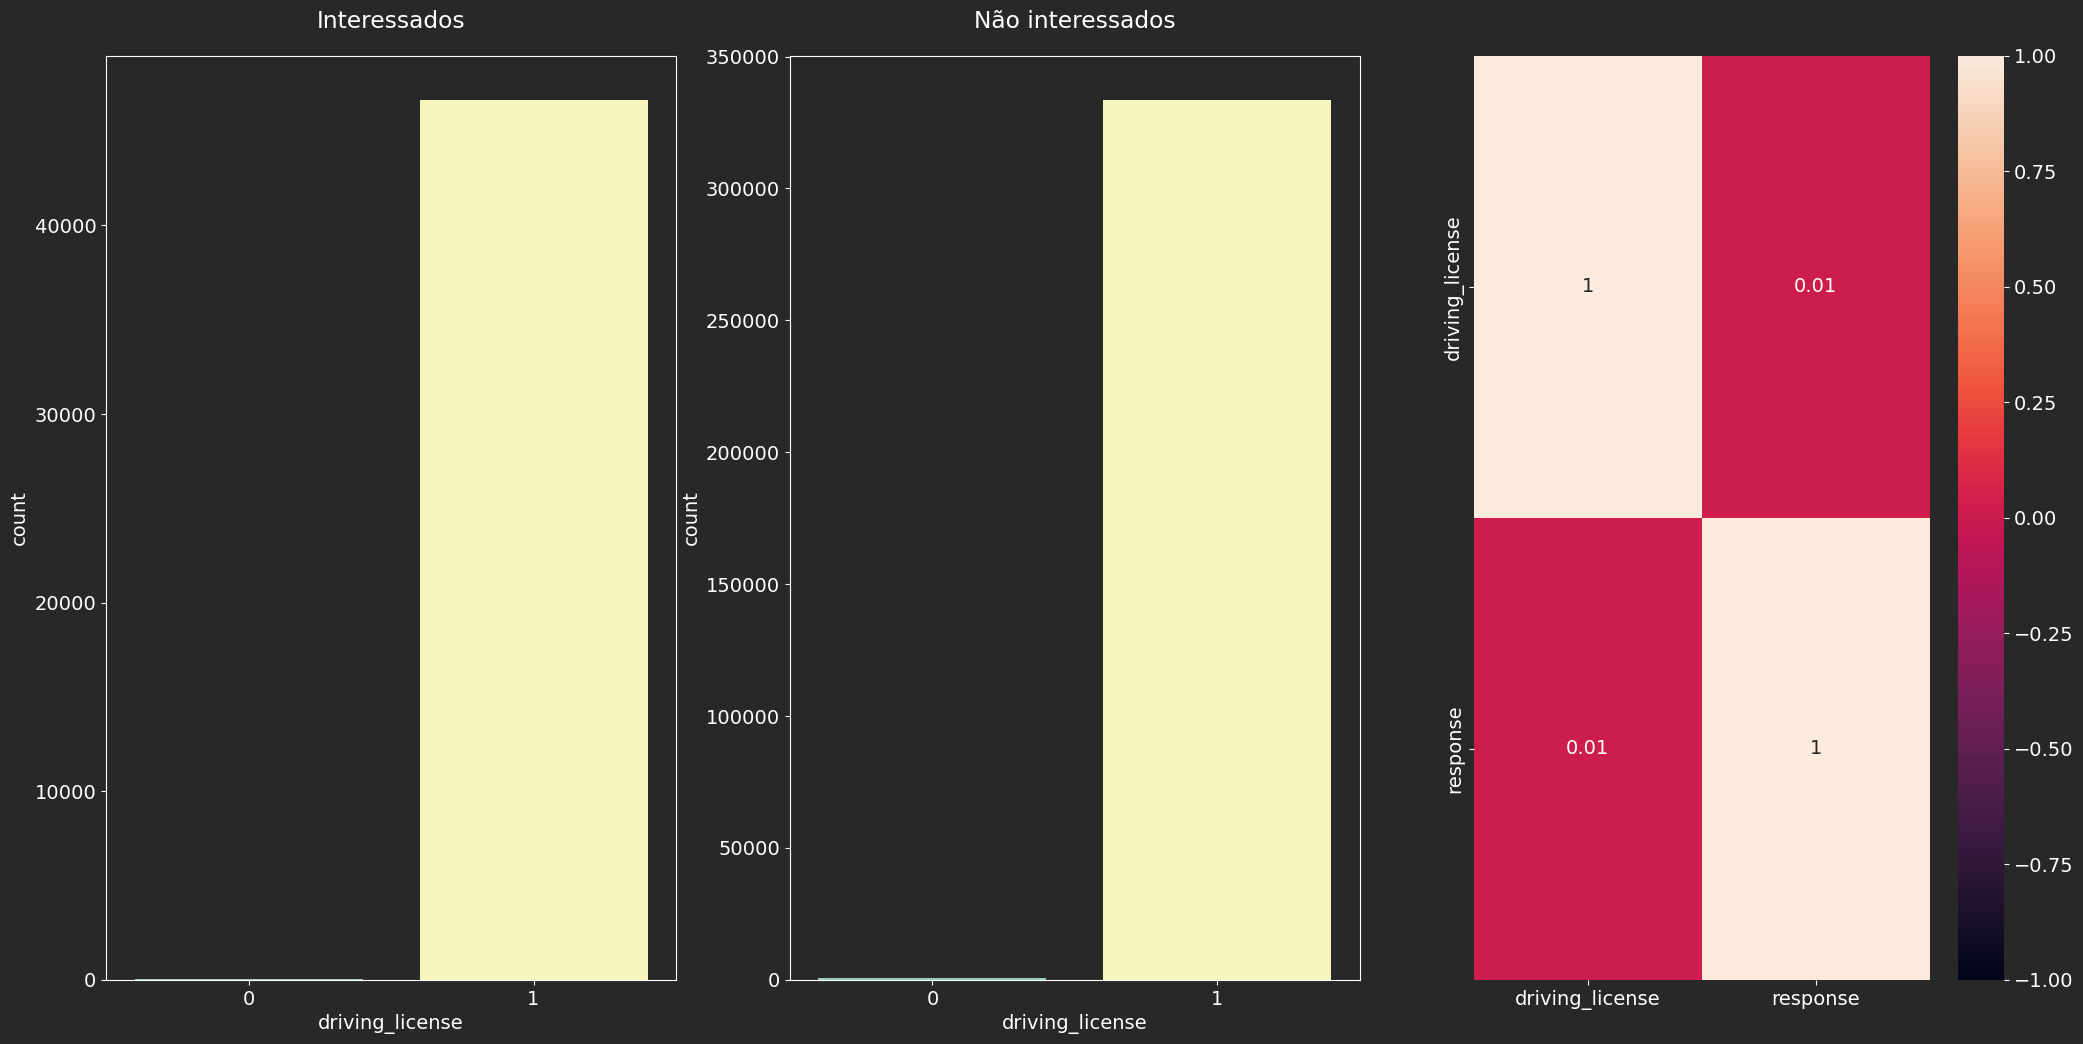

In [27]:
aux_drive_1 = df4[df4['response'] == 1]
plt.subplot(1, 3, 1)
sns.countplot(data=aux_drive_1, x=aux_drive_1['driving_license'])
plt.title('Interessados', pad=20)


aux_drive_0 = df4[df4['response'] == 0]
plt.subplot(1, 3, 2)
sns.countplot(data=aux_drive_0, x=aux_drive_0['driving_license'])
plt.title('Não interessados', pad=20)


plt.subplot(1, 3, 3)
driving_license_corr = df4[['driving_license', 'response']].copy()
sns.heatmap(driving_license_corr.corr(method='pearson'), annot=True, vmin=-1, vmax=1)

# Correlation found 0.01: Weak positive correlation.

### **H4.** Clientes da região 8 possuem mais interesse no seguro.
**False** - Clientes da região 28 possuem mais interesse no seguro.

<Axes: >

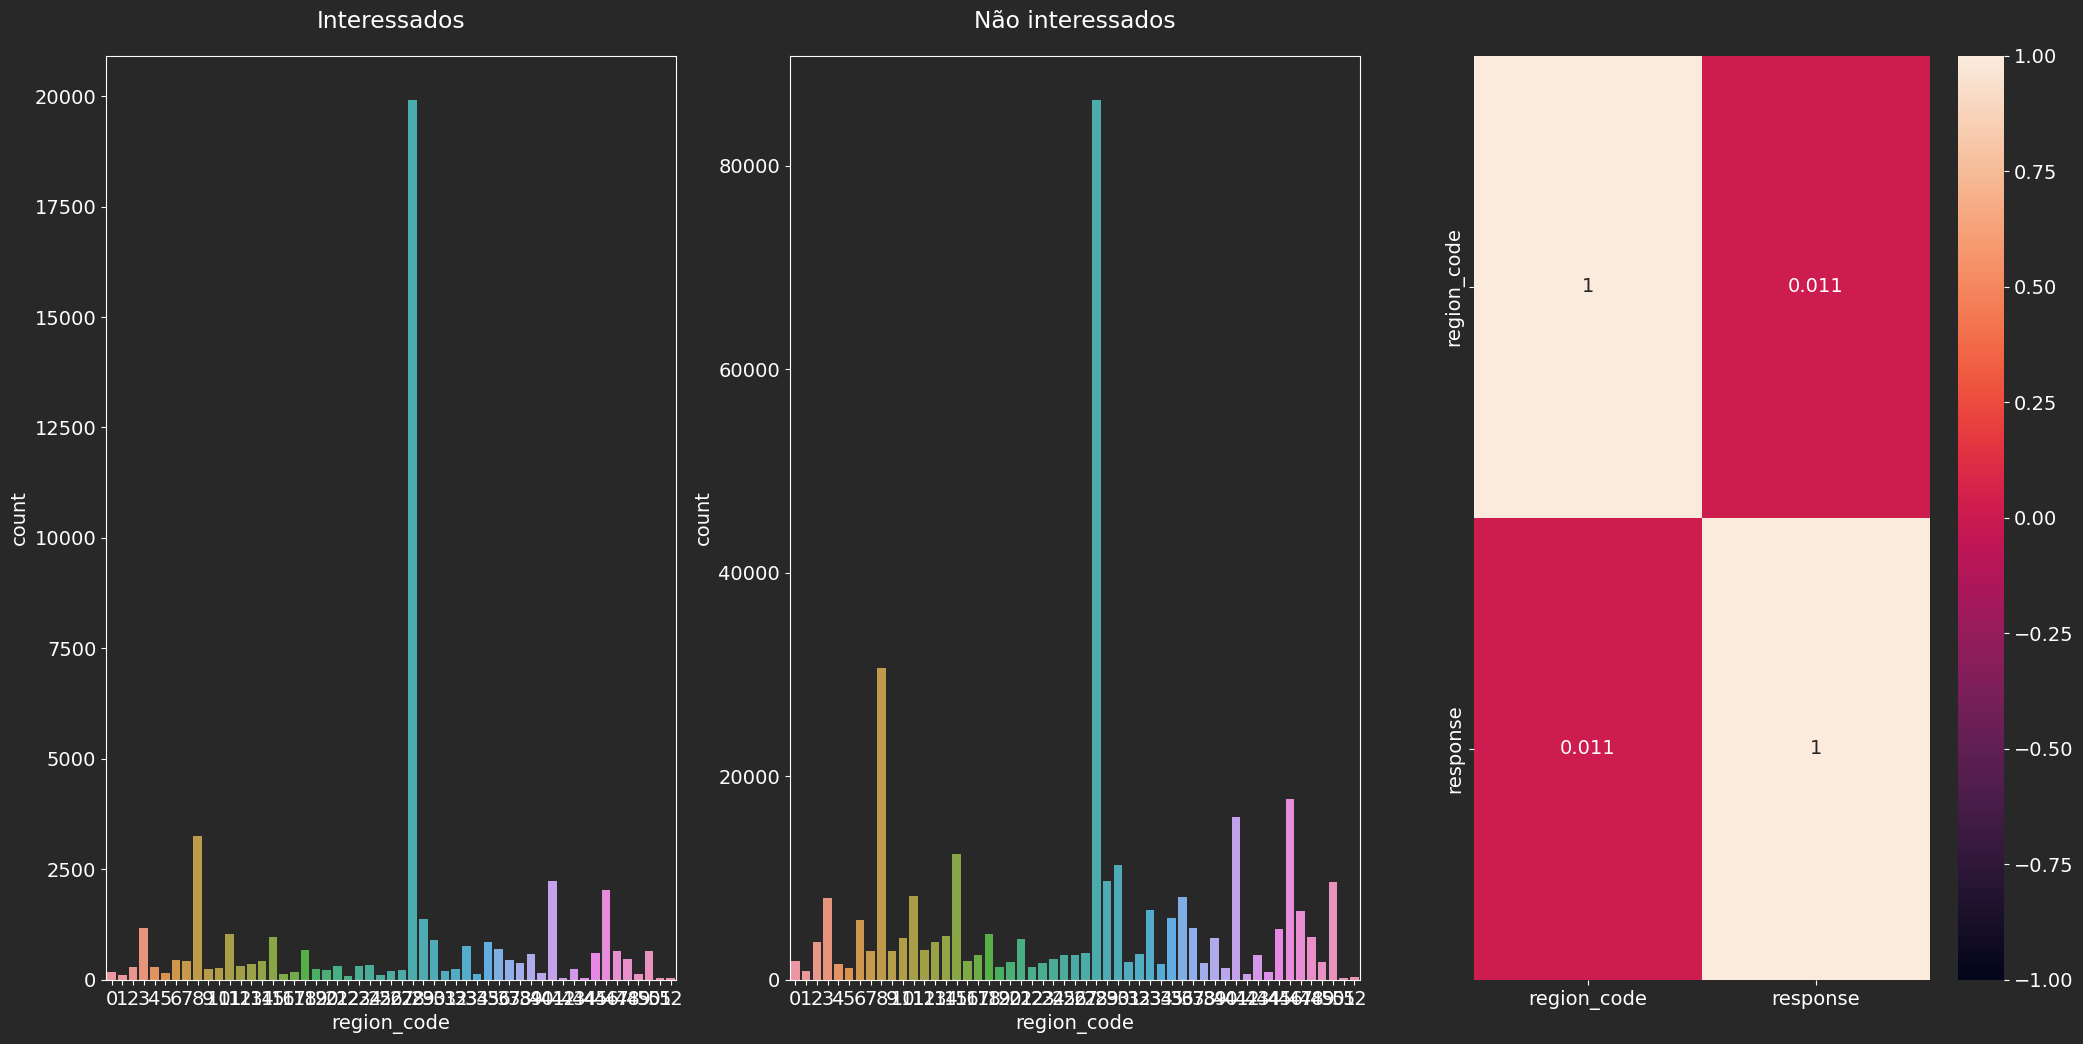

In [28]:
aux_channel_1 = df4[df4['response'] == 1]
plt.subplot(1, 3, 1)
sns.countplot(data=aux_channel_1, x=aux_channel_1['region_code'])
plt.title('Interessados', pad=20)


aux_channel_0 = df4[df4['response'] == 0]
plt.subplot(1, 3, 2)
sns.countplot(data=aux_channel_0, x=aux_channel_0['region_code'])
plt.title('Não interessados', pad=20)


plt.subplot(1, 3, 3)
region_code_corr = df4[['region_code', 'response']].copy()
sns.heatmap(region_code_corr.corr(method='pearson'), annot=True, vmin=-1, vmax=1)

# Correlation found 0.011: Very weak positive correlation.

# channel = aux_channel_1.loc[:,['region_code', 'id']].groupby(['region_code']).count().sort_values('id', ascending=False).reset_index()
# channel.head(10)

### **H5.** Clientes com o veículo já assegurado não possuem interesse no seguro.
**True** - Clientes com o veículo já assegurado não possuem interesse no seguro.

<Axes: >

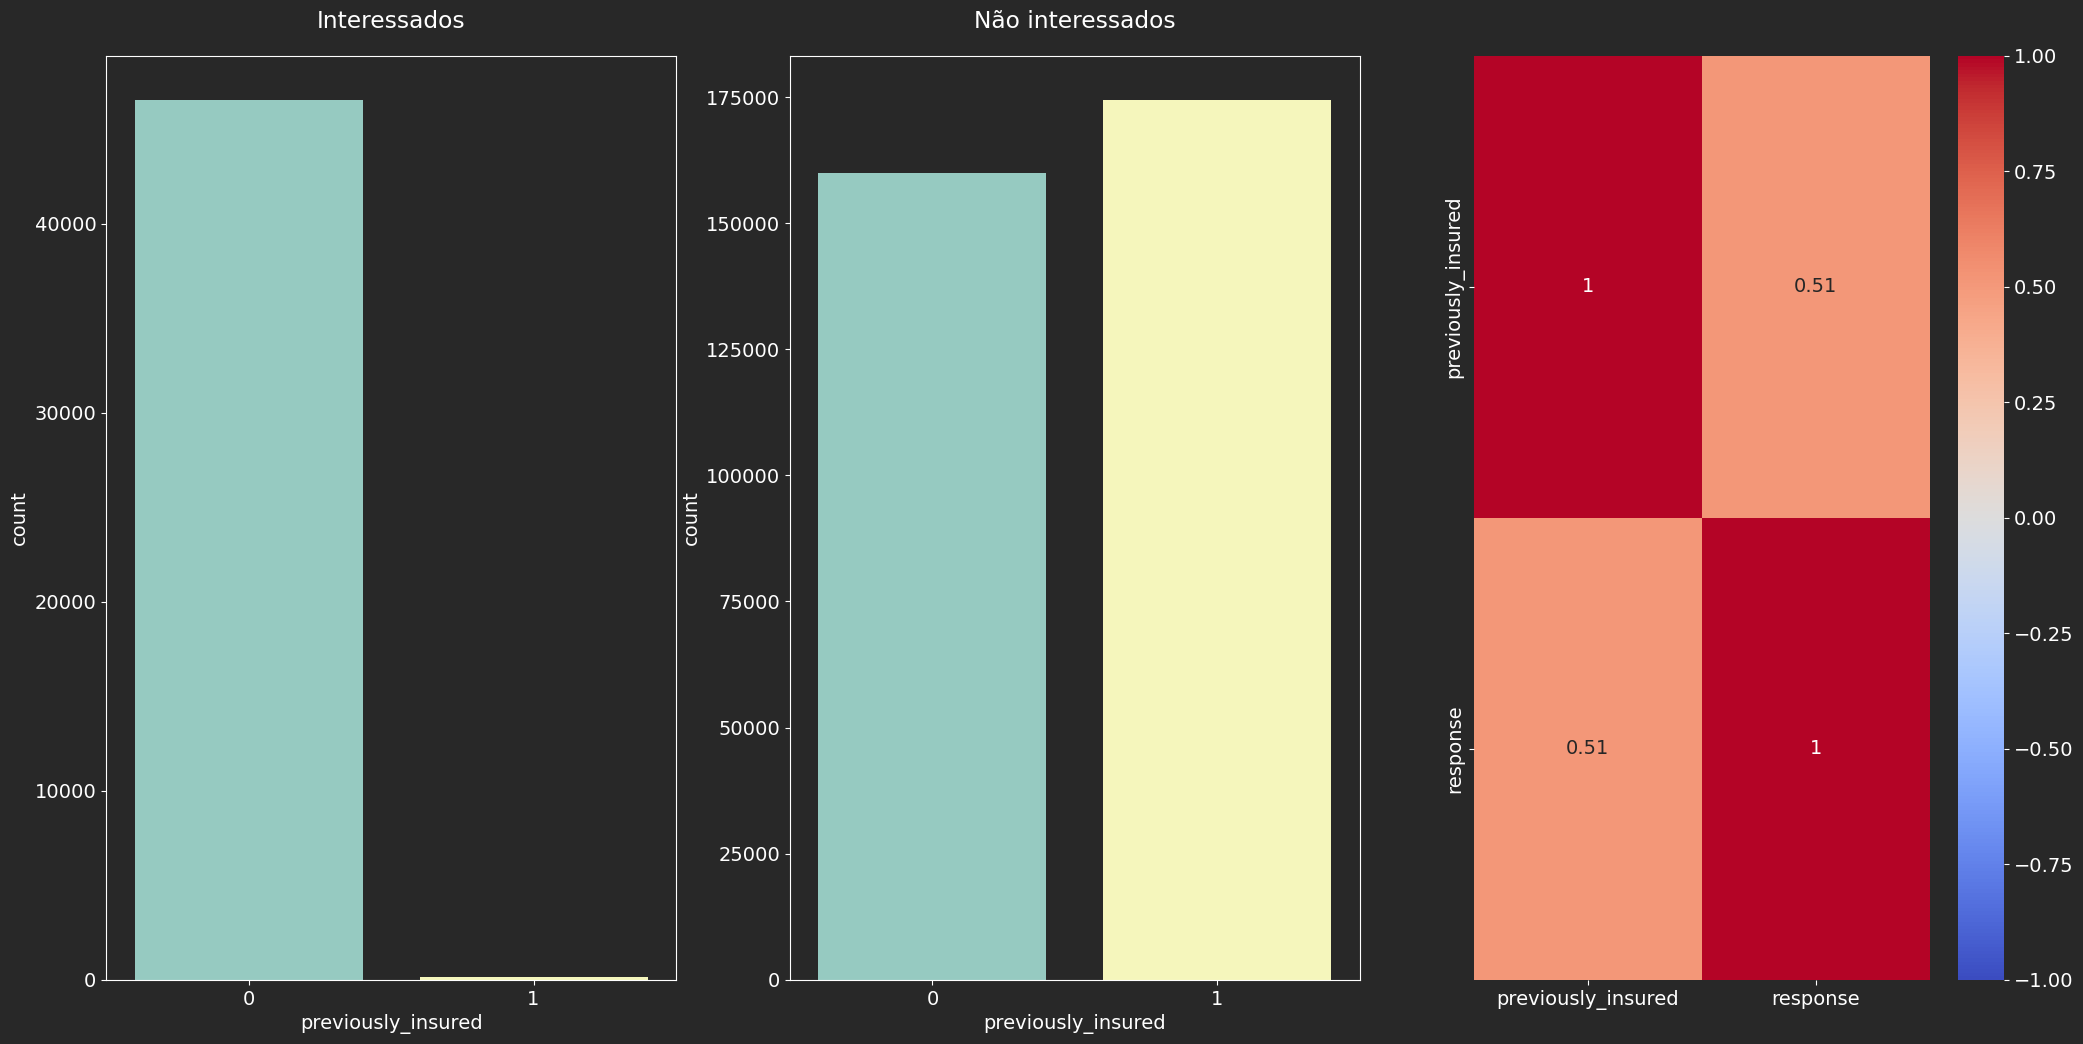

In [29]:
aux_prev_1 = df4[df4['response'] == 1]
plt.subplot(1, 3, 1)
sns.countplot(data=aux_prev_1, x=aux_prev_1['previously_insured'])
plt.title('Interessados', pad=20)


aux_prev_0 = df4[df4['response'] == 0]
plt.subplot(1, 3, 2)
sns.countplot(data=aux_prev_0, x=aux_prev_0['previously_insured'])
plt.title('Não interessados', pad=20)


previously_insured_corr = df4[['previously_insured', 'response']].copy()
plt.subplot(1, 3, 3)
phi_matrix = phik_matrix(previously_insured_corr, interval_cols=['response'])
sns.heatmap(data = phi_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

# Correlation found 0.51: Weak positive correlation.

### **H6.** Veículos mais novos possuem mais interesse no seguro.
**False** - Veículos entre 1 e 2 anos possuem mais interesse no seguro.


<Axes: >

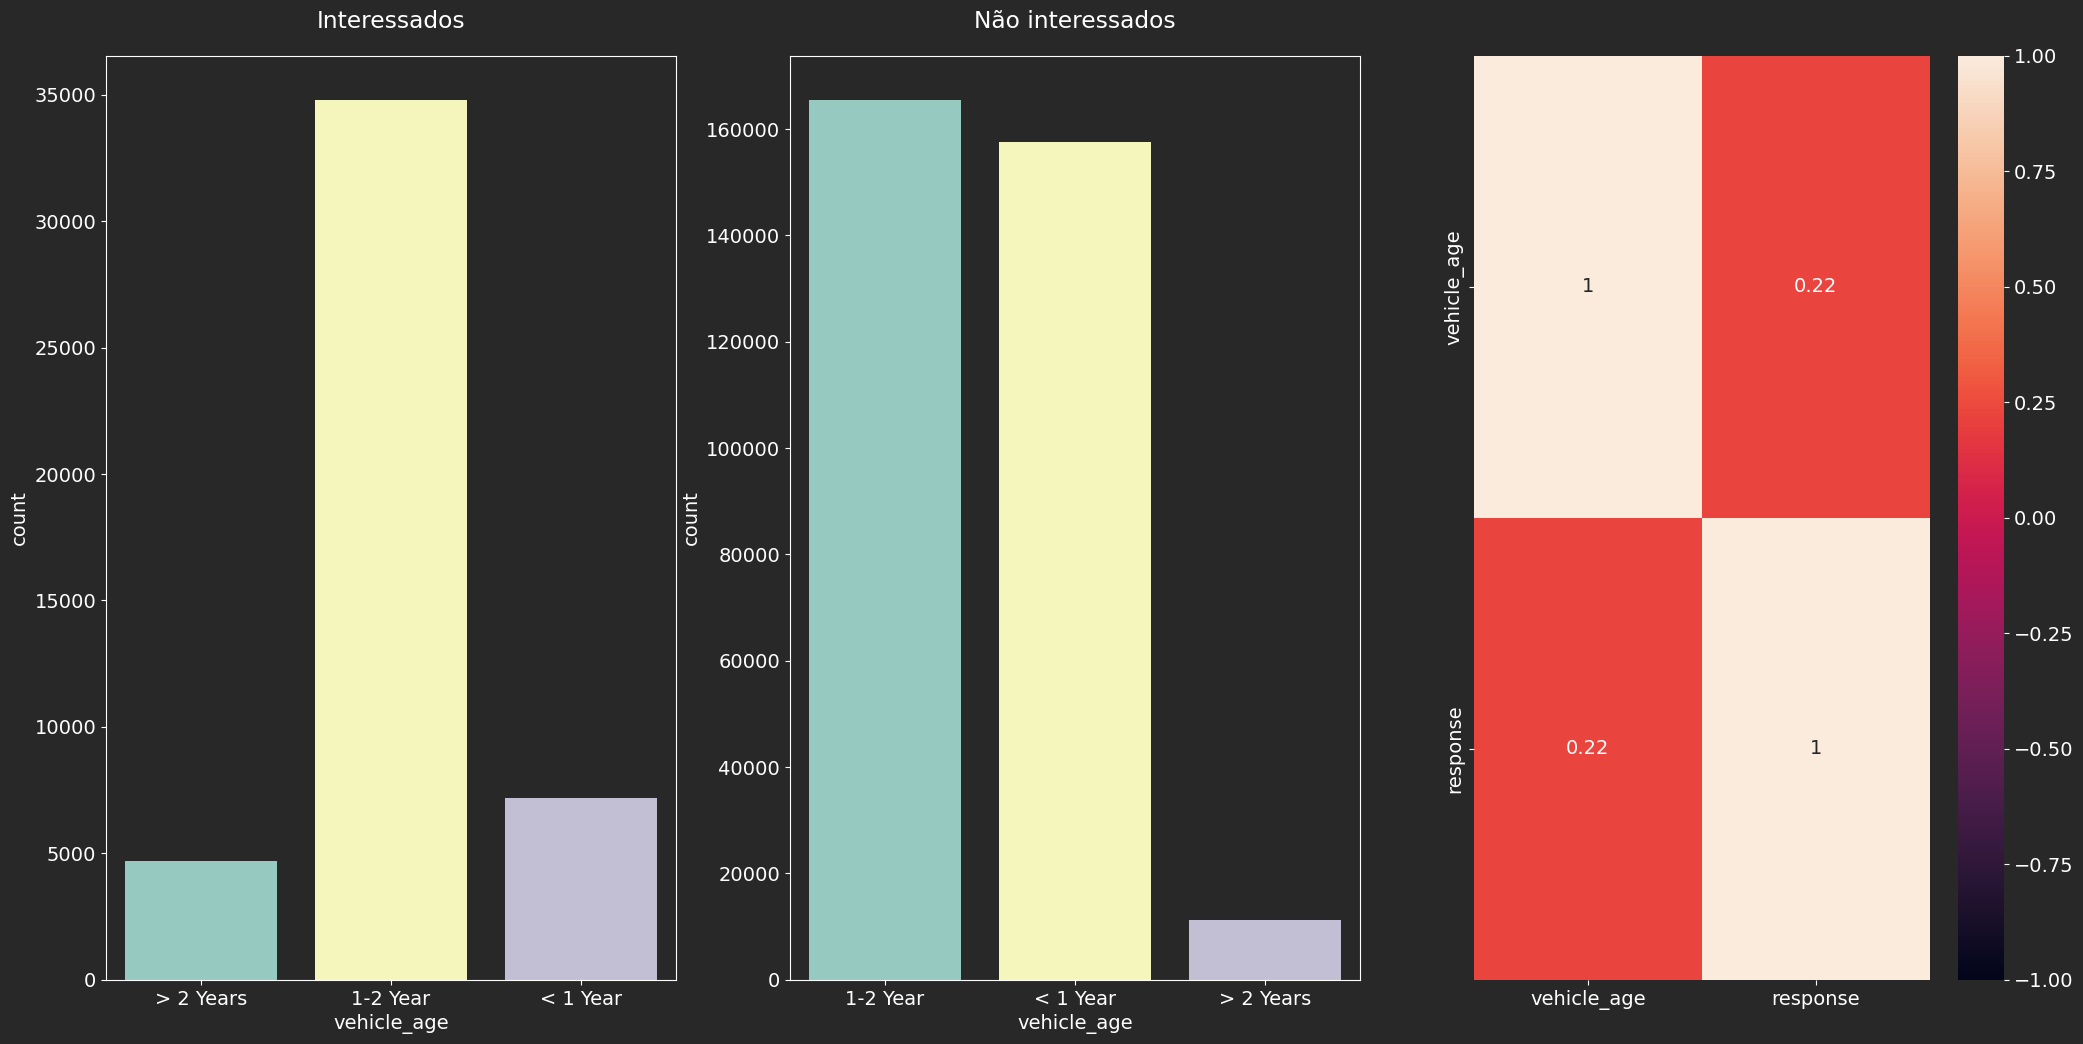

In [30]:
aux_vehicle_age_1 = df4[df4['response'] == 1]
plt.subplot(1, 3, 1)
sns.countplot(data=aux_vehicle_age_1, x=aux_vehicle_age_1['vehicle_age'])
plt.title('Interessados', pad=20)


aux_vehicle_age_0 = df4[df4['response'] == 0]
plt.subplot(1, 3, 2)
sns.countplot(data=aux_vehicle_age_0, x=aux_vehicle_age_0['vehicle_age'])
plt.title('Não interessados', pad=20)


plt.subplot(1, 3, 3)
vehicle_age_corr = df4[['vehicle_age', 'response']].copy()
vehicle_age_corr['vehicle_age'] = vehicle_age_corr['vehicle_age'].apply(lambda x: 0 if x == '< 1 Year' else 1 if x == '1-2 Year' else 2)
sns.heatmap(vehicle_age_corr.corr(method='pearson'), annot=True, vmin=-1, vmax=1)

# Correlation found 0.22: Very weak positive correlation.

### **H7.** Veículos já danificados possuem menos interesse no seguro.
**False** - Veículos já danificados possuem MAIS interesse no seguro.

<Axes: >

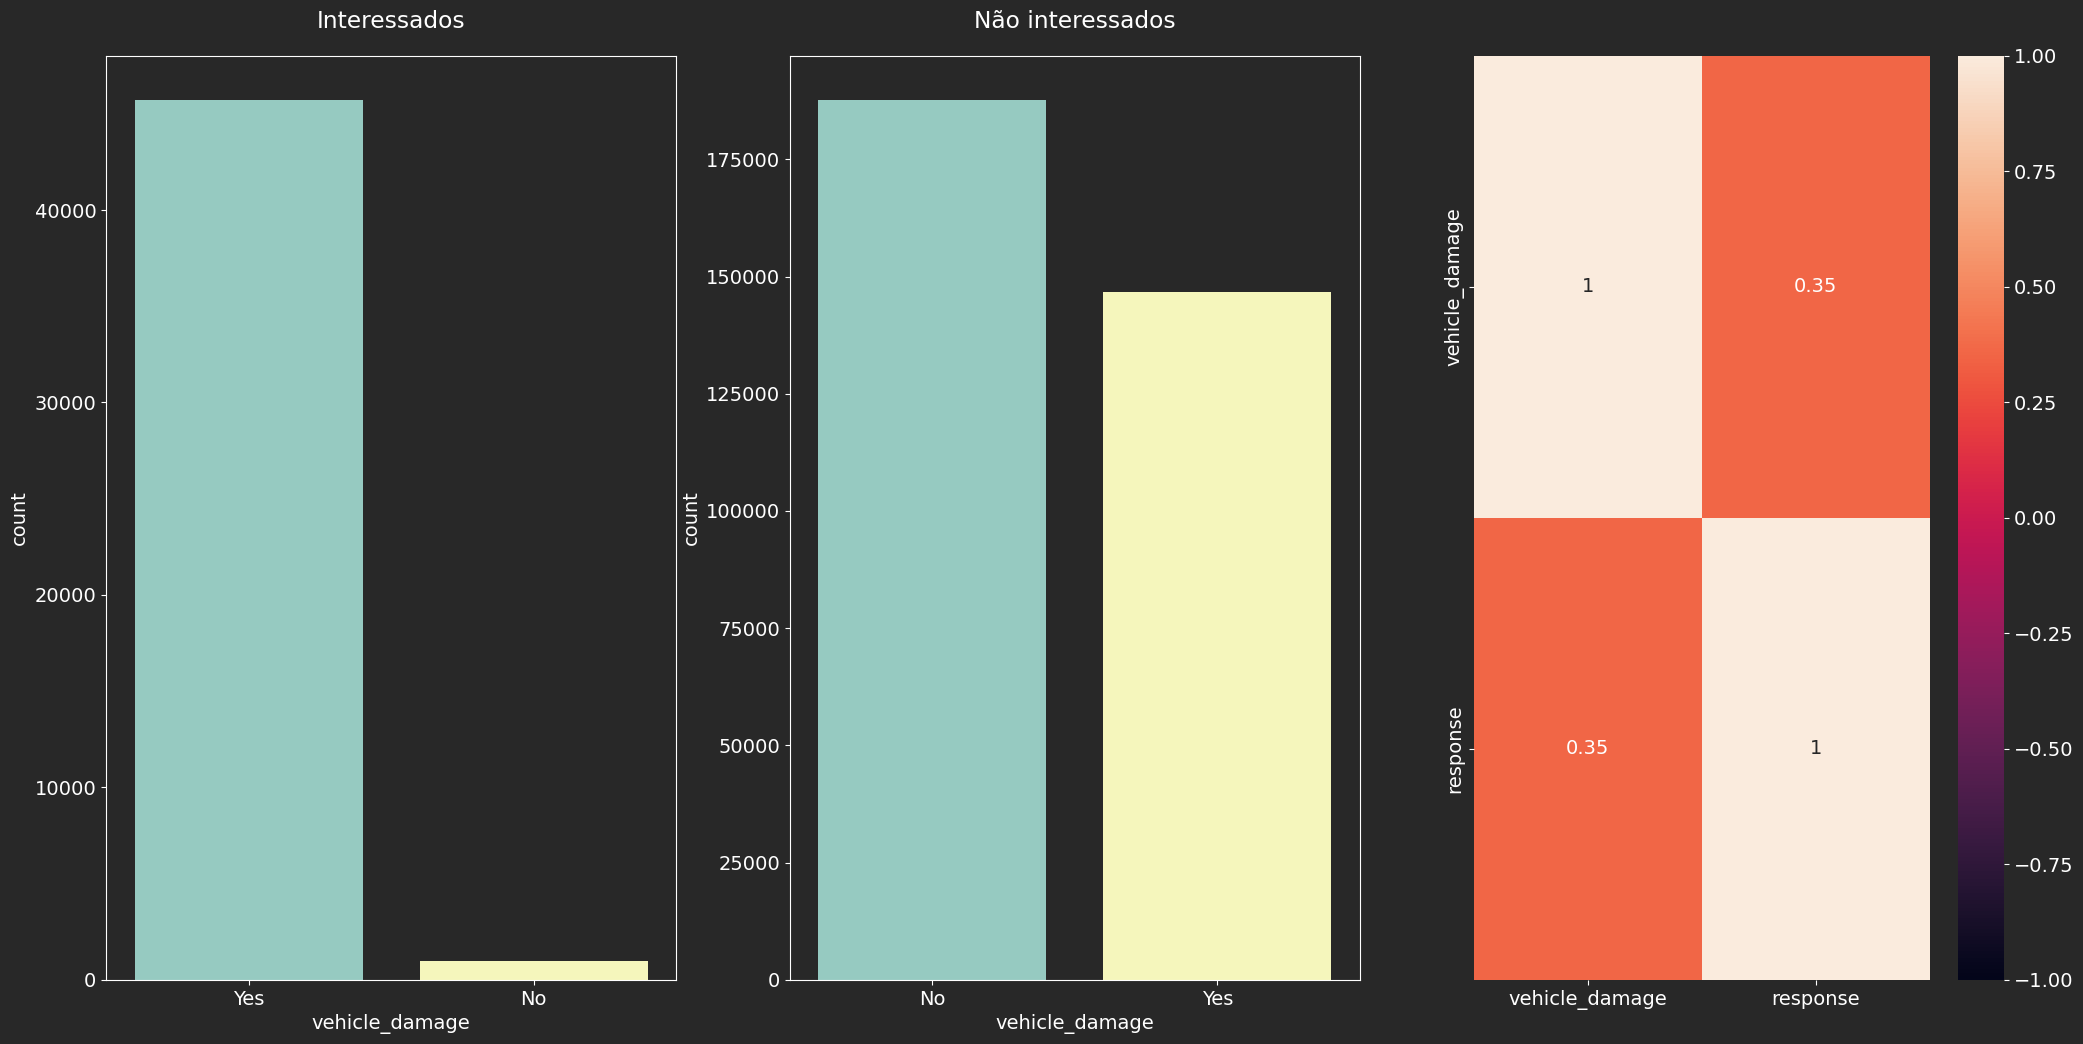

In [31]:
aux_vehicle_damage_1 = df4[df4['response'] == 1]
plt.subplot(1, 3, 1)
sns.countplot(data=aux_vehicle_damage_1, x=aux_vehicle_damage_1['vehicle_damage'])
plt.title('Interessados', pad=20)


aux_vehicle_damage_0 = df4[df4['response'] == 0]
plt.subplot(1, 3, 2)
sns.countplot(data=aux_vehicle_damage_0, x=aux_vehicle_damage_0['vehicle_damage'])
plt.title('Não interessados', pad=20)


plt.subplot(1, 3, 3)
vehicle_damage_corr = df4[['vehicle_damage', 'response']].copy()
vehicle_damage_corr['vehicle_damage'] = vehicle_damage_corr['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)
sns.heatmap(vehicle_damage_corr.corr(method='pearson'), annot=True, vmin=-1, vmax=1)

# Correlation found 0.35: Weak positive correlation.

### **H8.** Valores menores de seguro interessam mais os clientes.
**False** - Valores até 5000 possuem muitos clientes interessados mas também temos um grande interesse entre 25000 a 40000.

<Axes: >

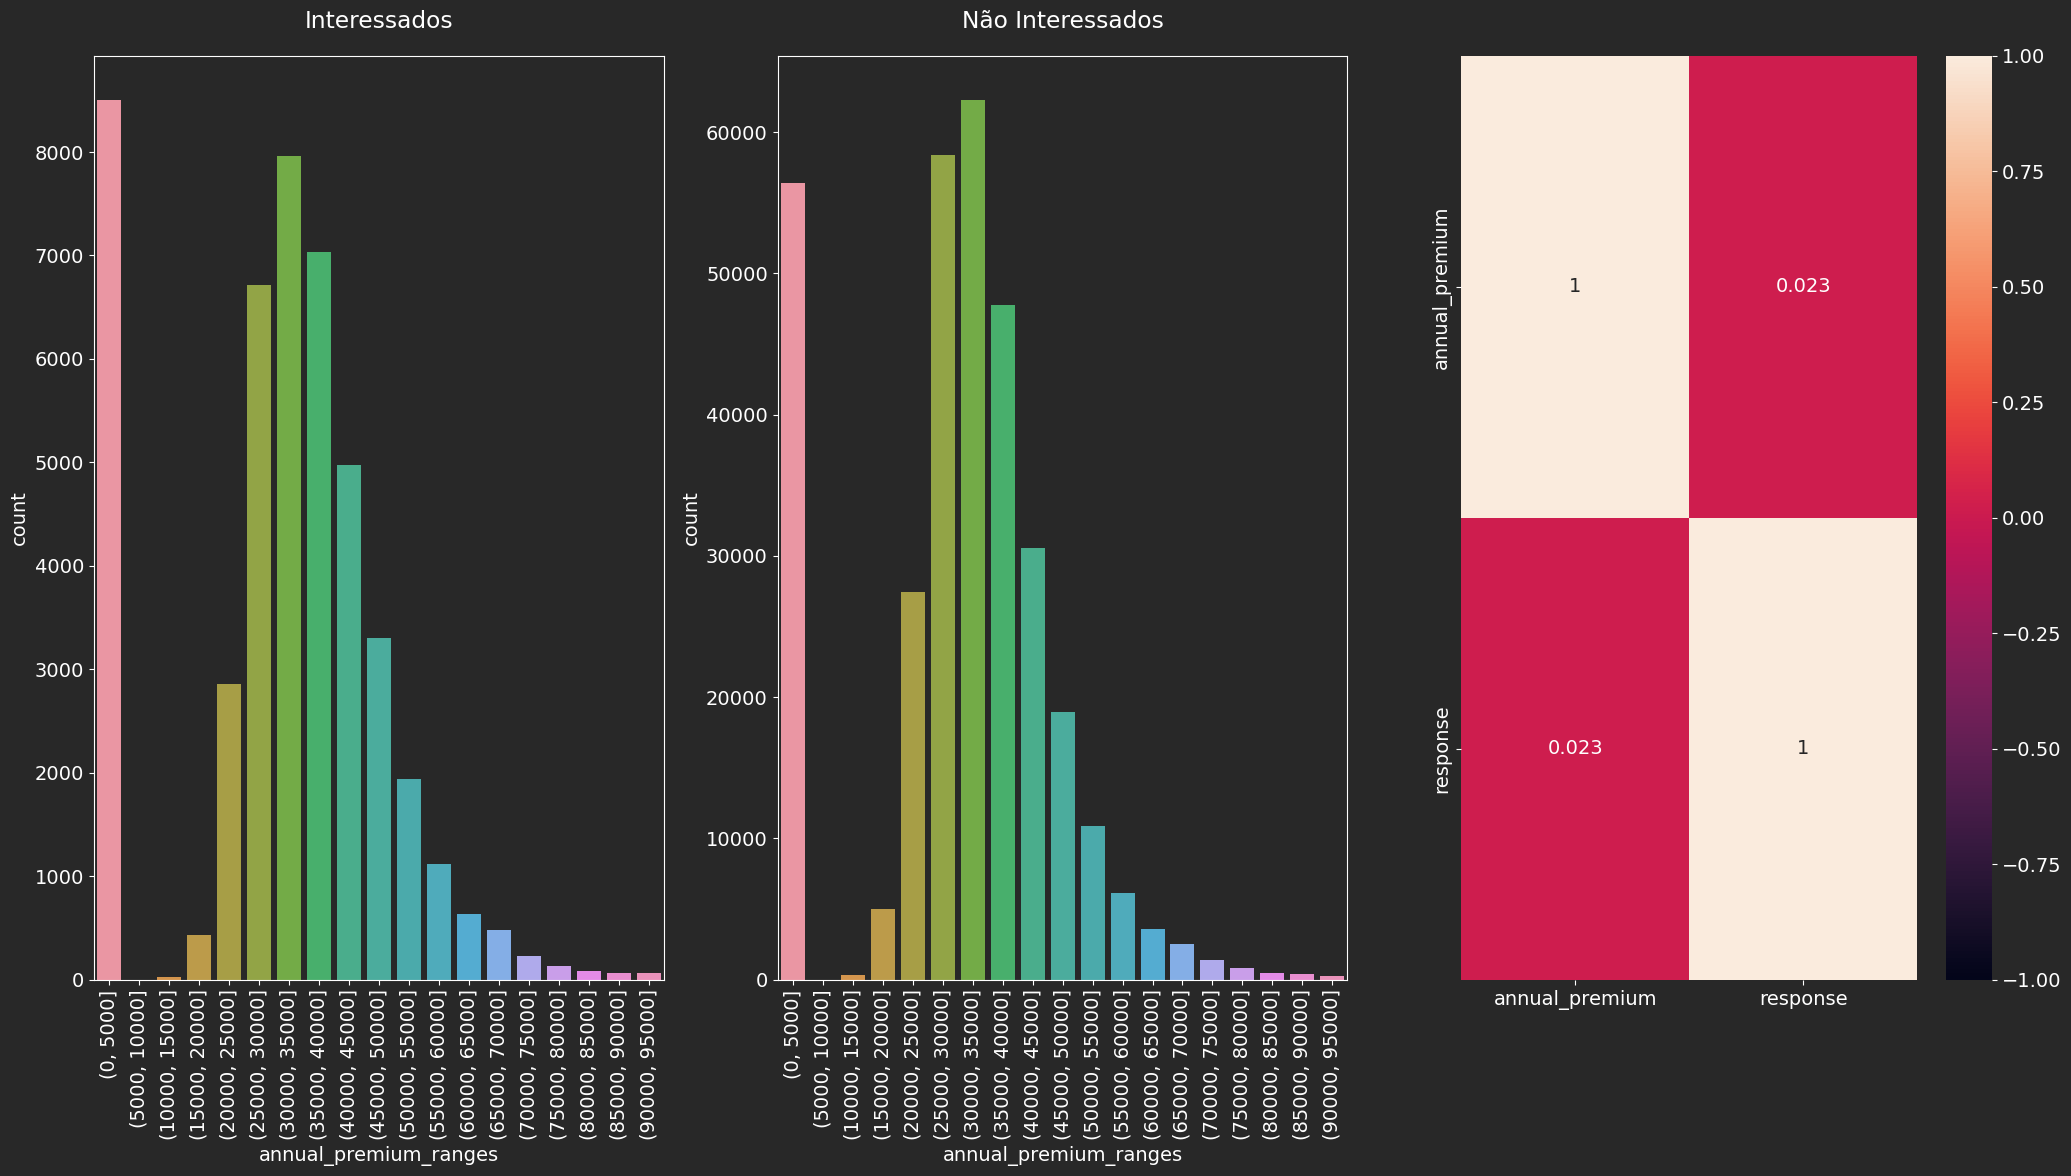

In [32]:
# Creating ranges
aux1 = df4[df4['response'] == 1].copy()
bins = list(np.arange(0, 100000, 5000))
aux1['annual_premium_ranges'] = pd.cut(aux1['annual_premium'], bins = bins)

aux0 = df4[df4['response'] == 0].copy()
bins = list(np.arange(0, 100000, 5000))
aux0['annual_premium_ranges'] = pd.cut(aux0['annual_premium'], bins = bins)


# plt.subplots_adjust(hspace=0.5)

plt.subplot(1, 3, 1)
sns.countplot(data=aux1, x=aux1['annual_premium_ranges'])
plt.xticks(rotation=90);
plt.title('Interessados', pad=20)

plt.subplot(1, 3, 2)
sns.countplot(data=aux0, x=aux0['annual_premium_ranges'])
plt.xticks(rotation=90);
plt.title('Não Interessados', pad=20)

# Correlation
plt.subplot(1, 3, 3)
anual_premium_corr = df4[['annual_premium', 'response']]
sns.heatmap(anual_premium_corr.corr(method='pearson'), annot=True, vmin=-1, vmax=1)

# Correlation found 0.023: Very weak positive correlation.


### **H9.** Os canais de vendas 122 e 160 possuem mais retorno positivo para o seguro.
**False** - Os canais de venda 26 e 124 possuem mais retorno positivo para o seguro.

<Axes: >

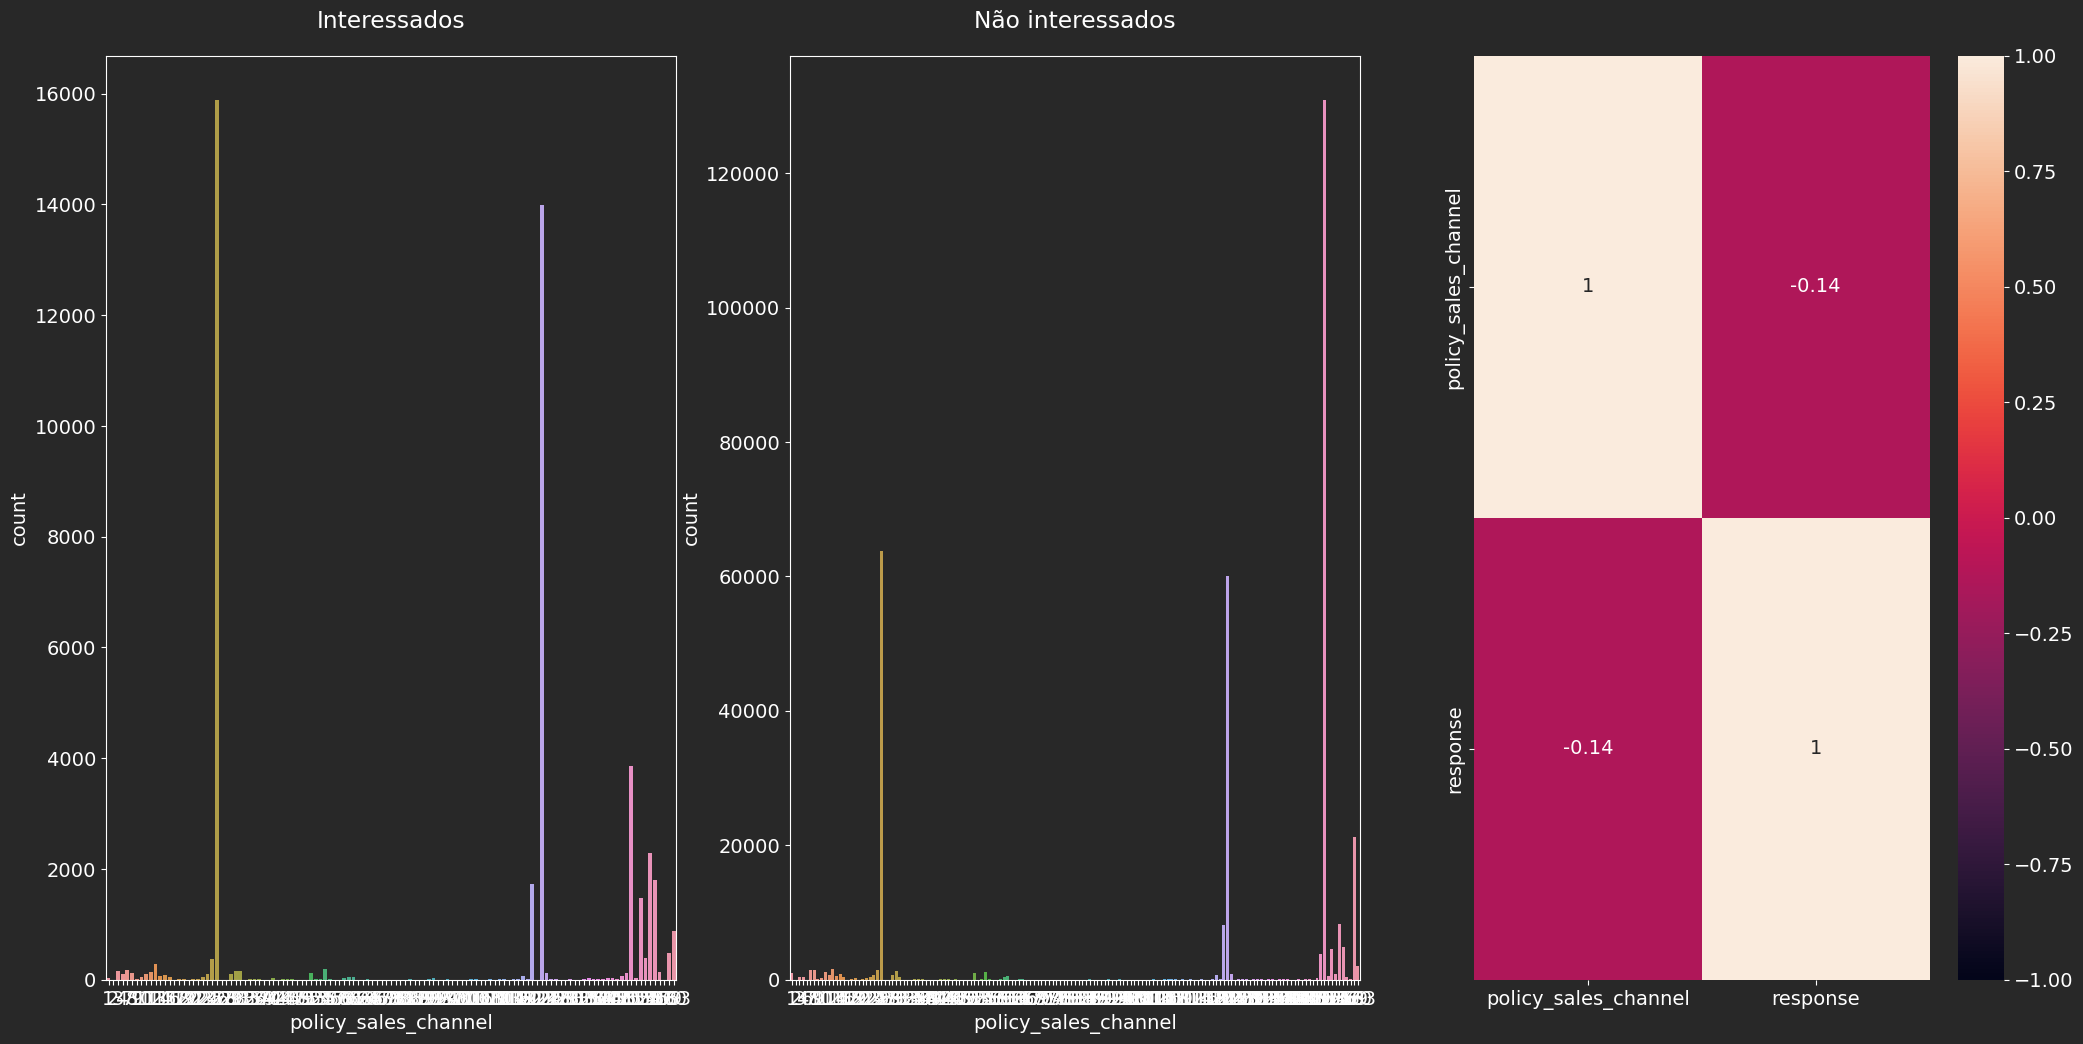

In [33]:
aux_channel_1 = df4[df4['response'] == 1]
plt.subplot(1, 3, 1)
sns.countplot(data=aux_channel_1, x=aux_channel_1['policy_sales_channel'])
plt.title('Interessados', pad=20)


aux_channel_0 = df4[df4['response'] == 0]
plt.subplot(1, 3, 2)
sns.countplot(data=aux_channel_0, x=aux_channel_0['policy_sales_channel'])
plt.title('Não interessados', pad=20)


plt.subplot(1, 3, 3)
policy_sales_channel_corr = df4[['policy_sales_channel', 'response']].copy()
sns.heatmap(policy_sales_channel_corr.corr(method='pearson'), annot=True, vmin=-1, vmax=1)

# Correlation found -0.14: Very weak negative correlation.

# channel = aux_channel_1.loc[:,['policy_sales_channel', 'id']].groupby(['policy_sales_channel']).count().sort_values('id', ascending=False).reset_index()
# channel.head(10)

### **H10.** Clientes a mais tempo assegurados possuem mais interesse no seguro de carro.
**True** - Clientes a mais tempo assegurados possuem mais interesse no seguro de carro.

<Axes: >

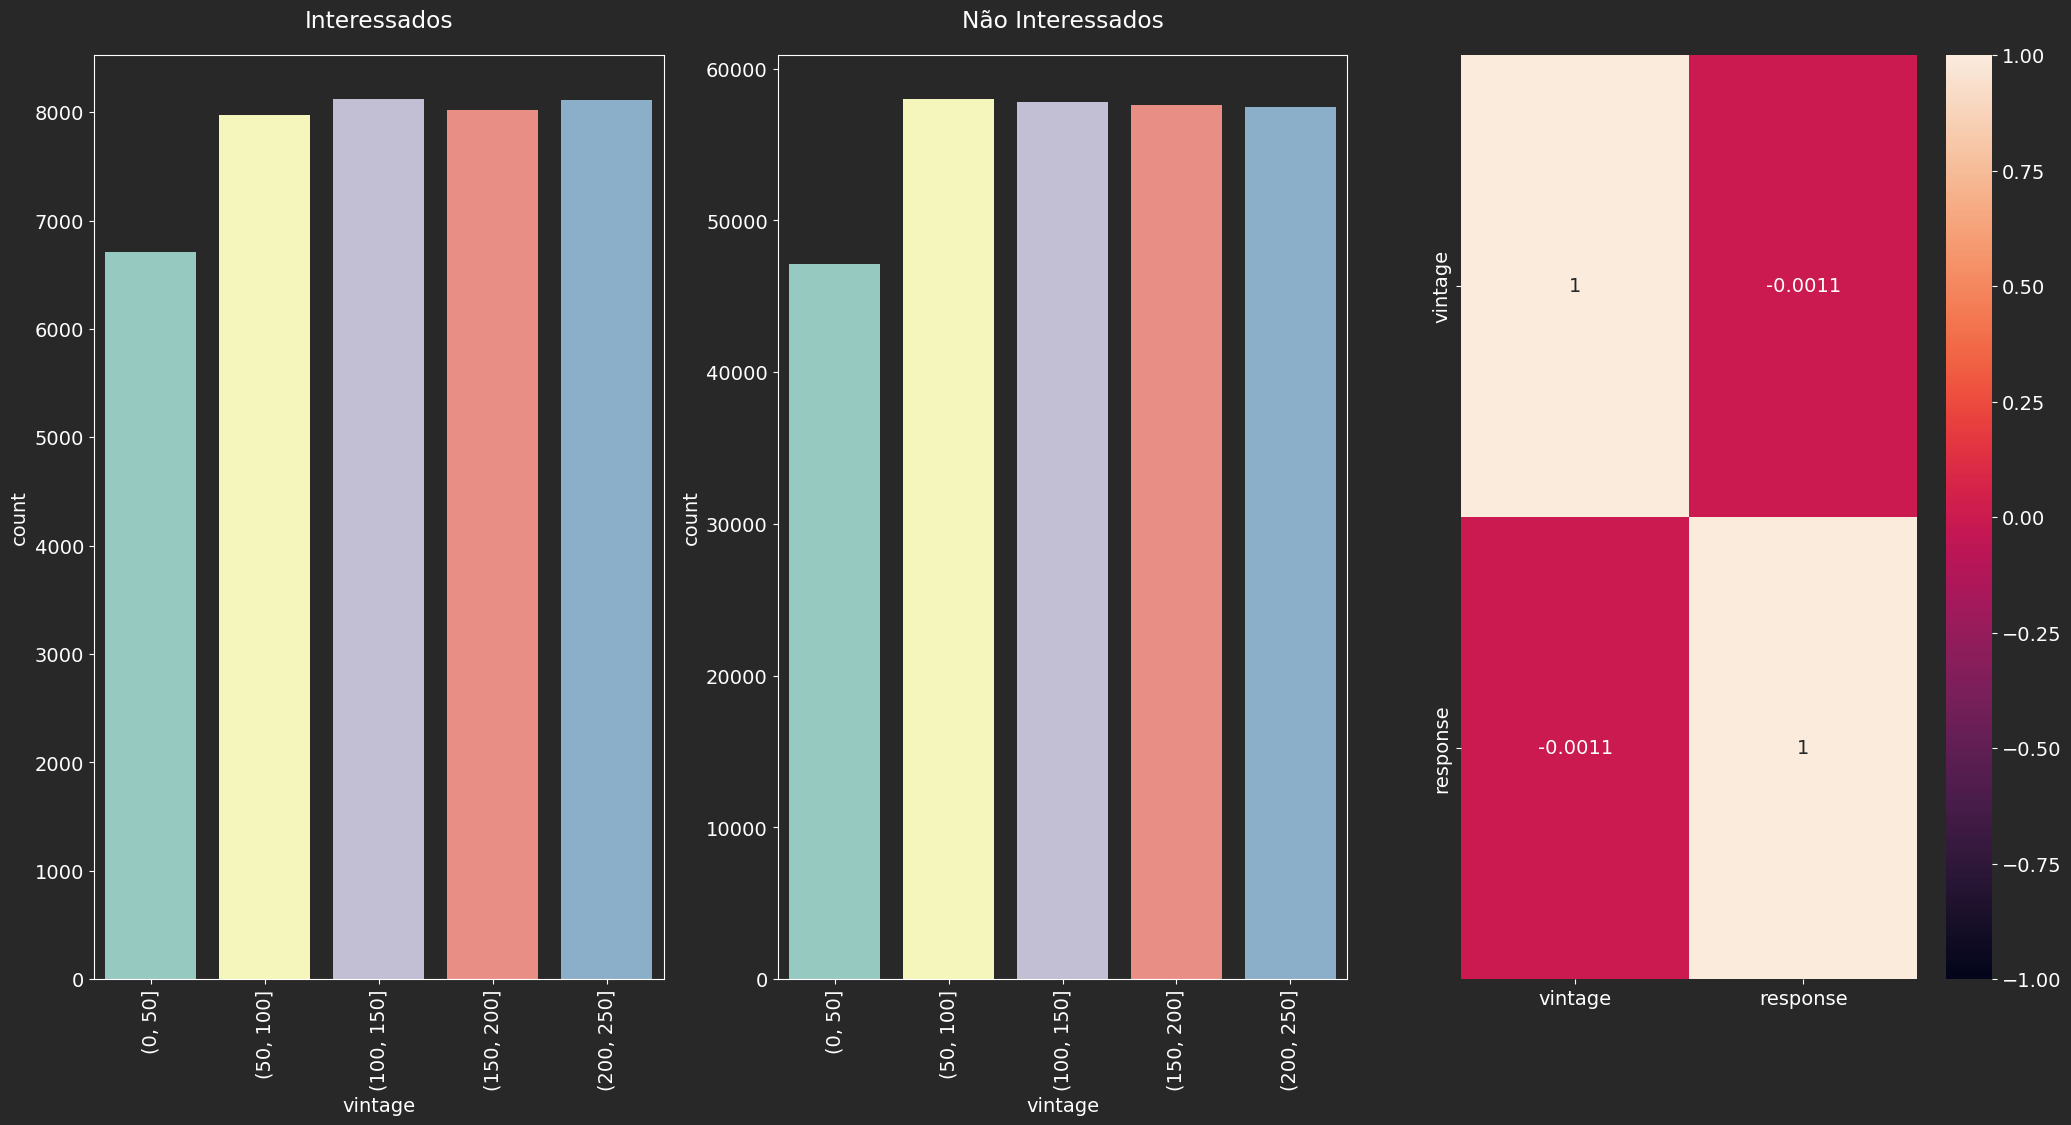

In [34]:
# Creating ranges
aux1 = df4[df4['response'] == 1].copy()
bins = list(np.arange(0, 300, 50))
aux1['vintage'] = pd.cut(aux1['vintage'], bins = bins)

aux0 = df4[df4['response'] == 0].copy()
bins = list(np.arange(0, 300, 50))
aux0['vintage'] = pd.cut(aux0['vintage'], bins = bins)


# plt.subplots_adjust(hspace=0.5)

plt.subplot(1, 3, 1)
sns.countplot(data=aux1, x=aux1['vintage'])
plt.xticks(rotation=90);
plt.title('Interessados', pad=20)

plt.subplot(1, 3, 2)
sns.countplot(data=aux0, x=aux0['vintage'])
plt.xticks(rotation=90);
plt.title('Não Interessados', pad=20)

# Correlation
plt.subplot(1, 3, 3)
vintage_corr = df4[['vintage', 'response']]
sns.heatmap(vintage_corr.corr(method='pearson'), annot=True, vmin=-1, vmax=1)

# Correlation found -0.0011: Very weak negative correlation.

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

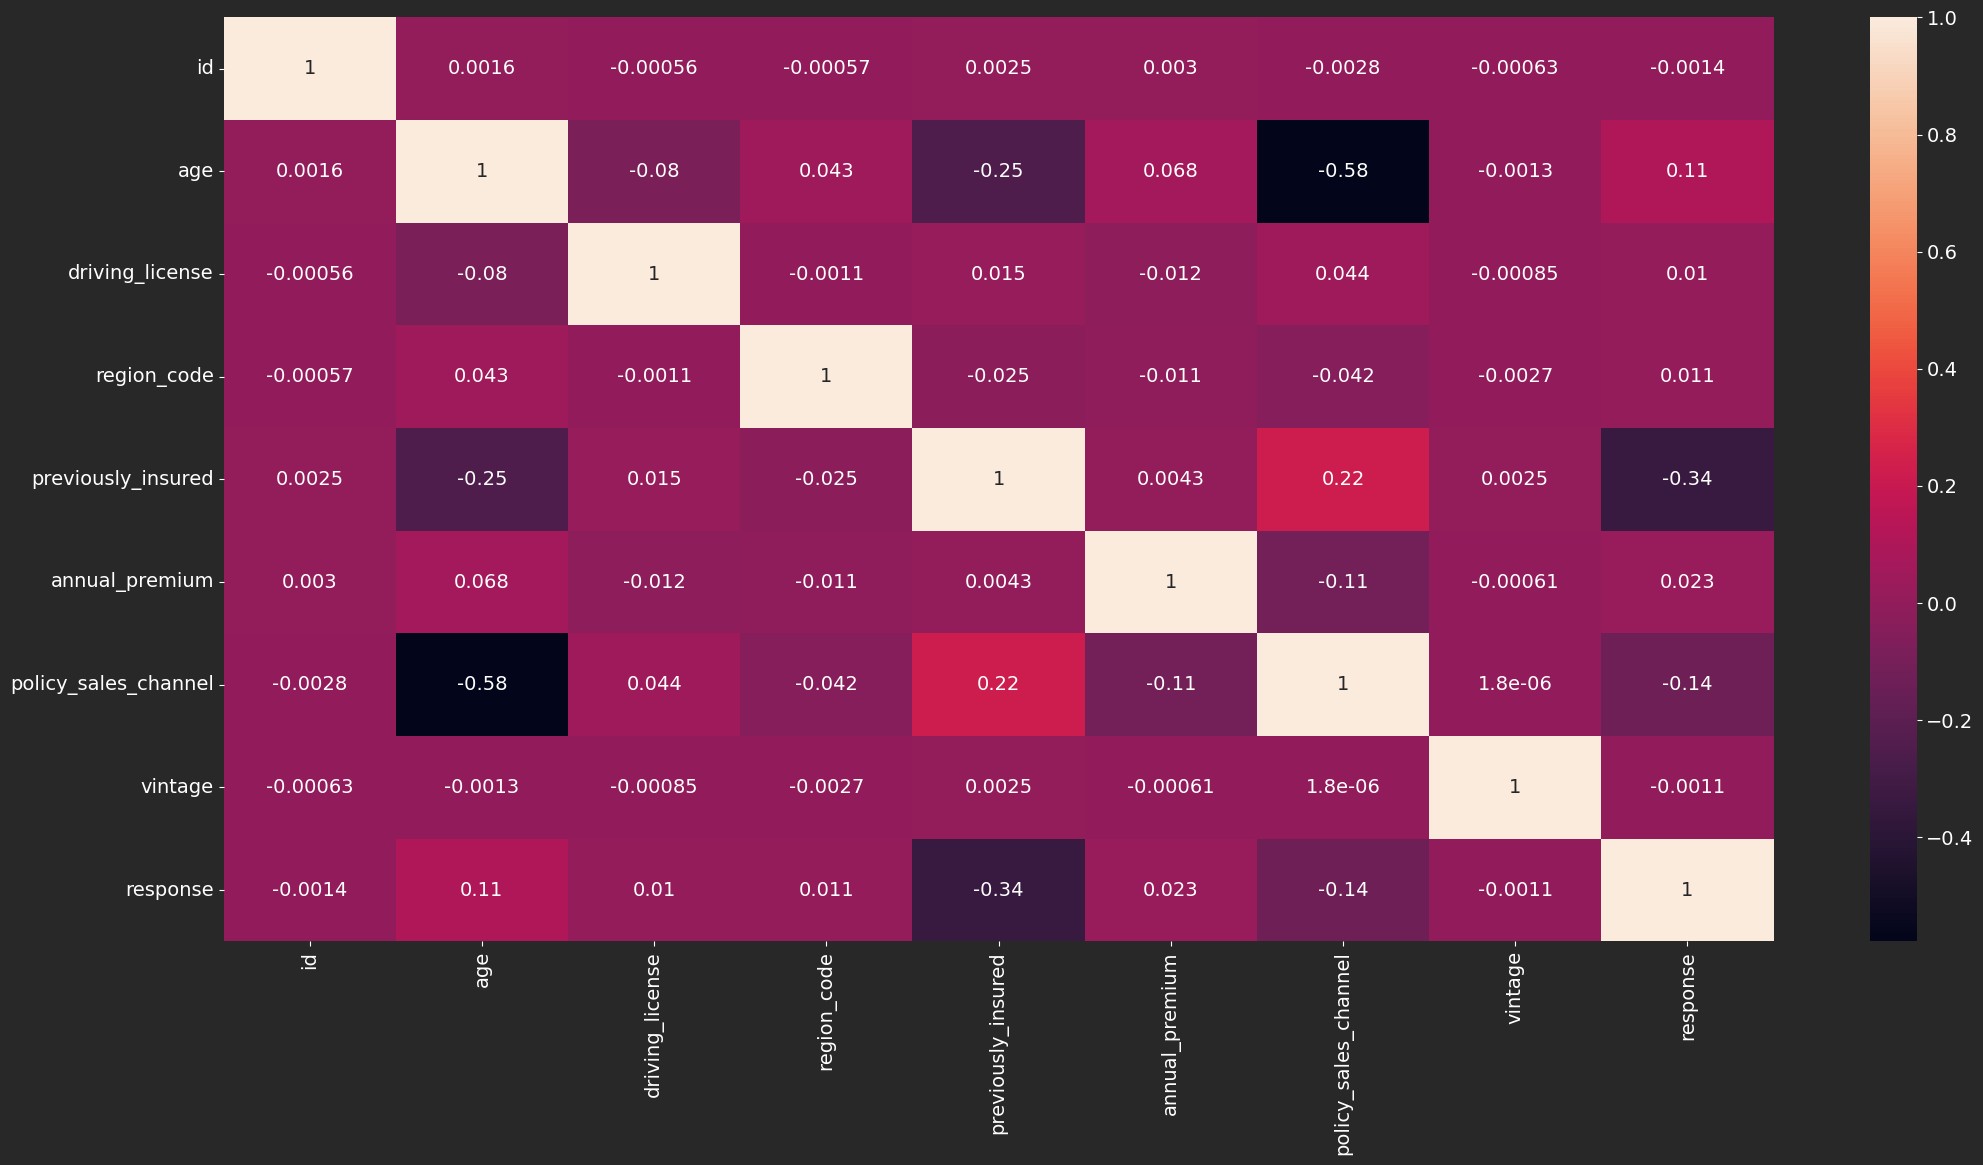

In [35]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

In [36]:
a = df4.select_dtypes(include='object')
a

,gender,vehicle_age,vehicle_damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No
...,...,...,...
381104,Male,1-2 Year,No
381105,Male,< 1 Year,No
381106,Male,< 1 Year,No
381107,Female,> 2 Years,Yes


In [37]:
# Calculate Cramer V

a1 = cramer_v(a['gender'], a['gender'])
a2 = cramer_v(a['gender'], a['vehicle_age'])
a3 = cramer_v(a['gender'], a['vehicle_damage'])

a4 = cramer_v(a['vehicle_age'], a['gender'])
a5 = cramer_v(a['vehicle_age'], a['vehicle_age'])
a6 = cramer_v(a['vehicle_age'], a['vehicle_damage'])

a7 = cramer_v(a['vehicle_damage'], a['gender'])
a8 = cramer_v(a['vehicle_damage'], a['vehicle_age'])
a9 = cramer_v(a['vehicle_damage'], a['vehicle_damage'])

d = pd.DataFrame({ 'gender': [a1, a2, a3],
              'vehicle_age': [a4, a5, a6],
              'vehicle_damage': [a7, a8, a9], })


# Final dataset
# Passa todas as colunas como index da tabela
d = d.set_index(d.columns)
d

,gender,vehicle_age,vehicle_damage
gender,0.999996,0.166786,0.091601
vehicle_age,0.166786,1.000003,0.396893
vehicle_damage,0.091601,0.396893,0.999996


<Axes: >

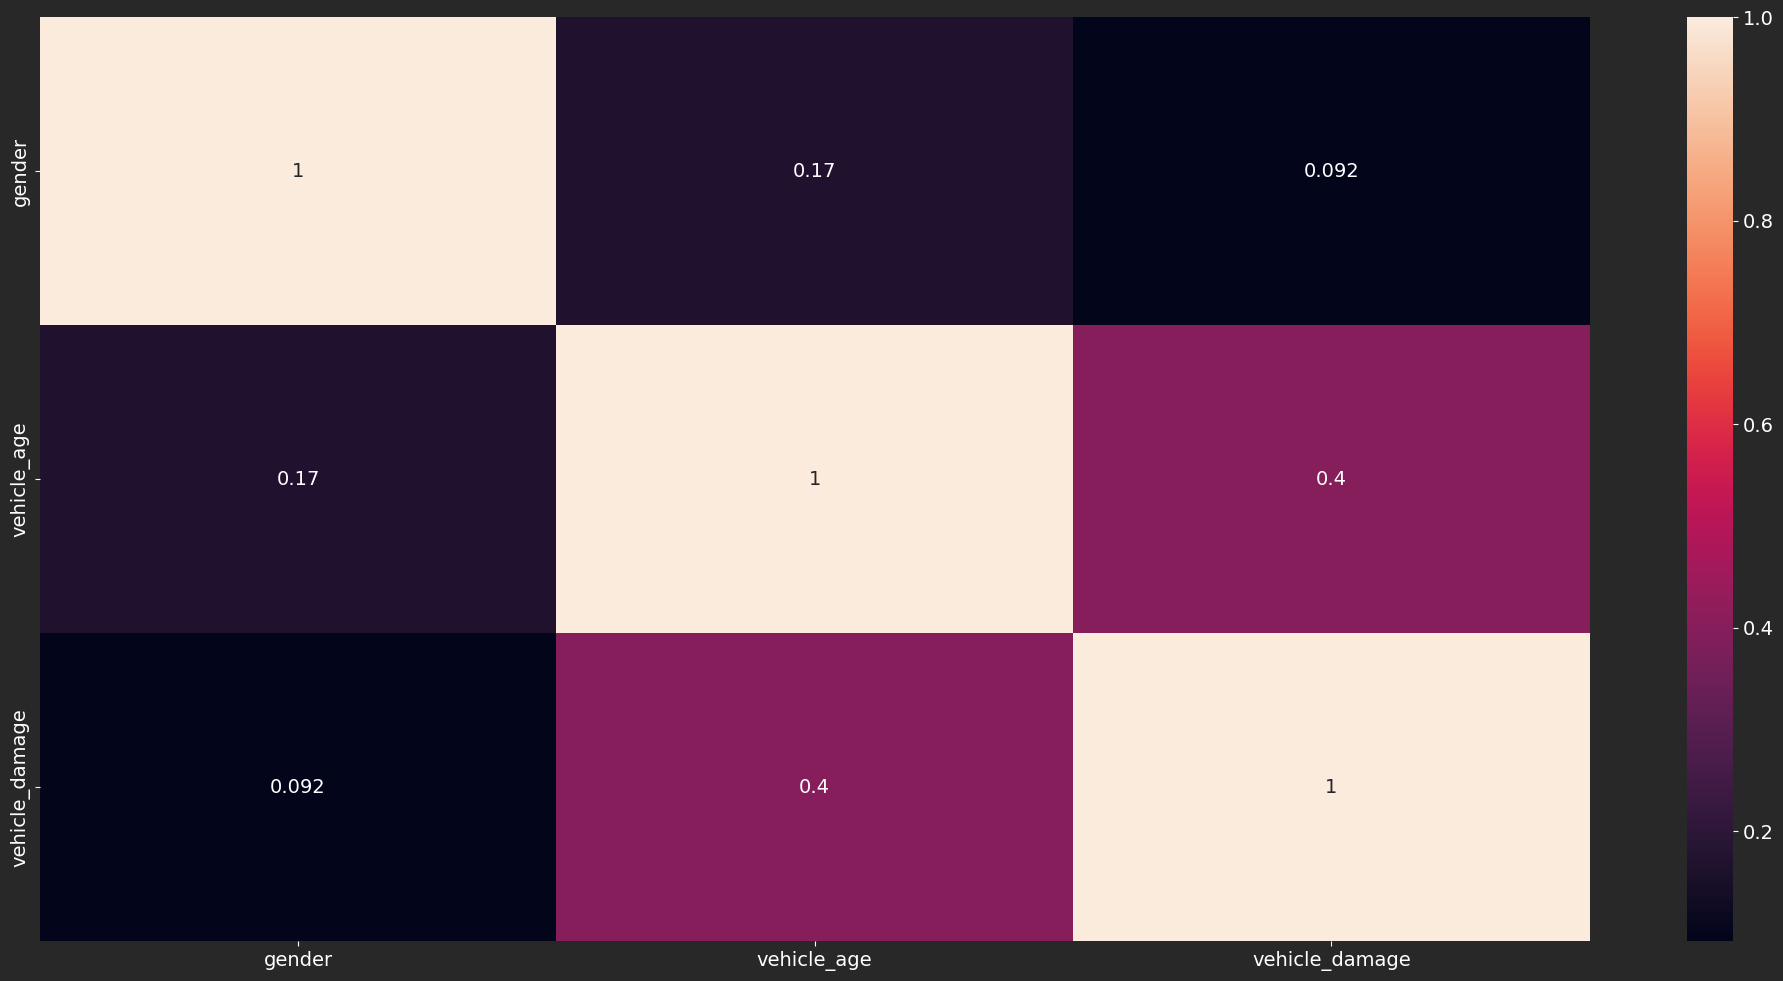

In [38]:
sns.heatmap(d, annot=True)

# 5.0 Data Preparation

In [39]:
df5 = df4.copy()

# no treino fit_transform e no teste só transform
# fazer um rs ou mms para cada coluna.

# evitar o label encoder

## 5.1 Split train and test

In [40]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.2 Standardization

In [41]:
ss = StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## 5.3 Rescaling

In [42]:
# Rescaling
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

## 5.4 Encoder

In [43]:
# Enconding vars

#-----------------------------------------------------------------------------------------------------

# Gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)

#-----------------------------------------------------------------------------------------------------

# Region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)

#-----------------------------------------------------------------------------------------------------

# Vehicle_age - One Hot Encoding / Frequency Encoding
one_hot_vehicle_age = OneHotEncoder()

vehicle_age_encoded = one_hot_vehicle_age.fit_transform(df5[['vehicle_age']])

columns_created = one_hot_vehicle_age.get_feature_names_out()

df5[columns_created] = vehicle_age_encoded.toarray()

df5 = df5.drop(columns=['vehicle_age'])

# Usar o one hot encoding, fit_Transform treino, validação só transform
# get_dummies pode vazar dados dependendo de como usa
# já o one hot encoding pode usar numa pipeline

#-----------------------------------------------------------------------------------------------------

# Policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel' ).size() / len(df5) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

#-----------------------------------------------------------------------------------------------------

# Vehicle_damage - transform to 0,1
df5['vehicle_damage'] = df5['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

C:\Users\andre\AppData\Local\Temp\ipykernel_10908\2545586615.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)


## 5.5 Validation Preparation

In [44]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map(target_encode_gender)

#-----------------------------------------------------------------------------------------------------

# age
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

#-----------------------------------------------------------------------------------------------------

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

#-----------------------------------------------------------------------------------------------------

# vehicle_age
vehicle_age_encoded = one_hot_vehicle_age.transform(x_validation[['vehicle_age']])
columns_created = one_hot_vehicle_age.get_feature_names_out()
x_validation[columns_created] = vehicle_age_encoded.toarray()
x_validation = x_validation.drop(columns=['vehicle_age'])

#-----------------------------------------------------------------------------------------------------

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

#-----------------------------------------------------------------------------------------------------

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

#-----------------------------------------------------------------------------------------------------

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values)

#-----------------------------------------------------------------------------------------------------

#vehicle_damage
x_validation['vehicle_damage'] = x_validation['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

#-----------------------------------------------------------------------------------------------------

# fillna
x_validation = x_validation.fillna(0)

C:\Users\andre\AppData\Local\Temp\ipykernel_10908\245532324.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map(target_encode_gender)


# 6.0 Feature Selection

In [ ]:
# # Model definition
# forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# # Data preparation
# x_train_n = df5.drop(['id', 'response'], axis=1)
# y_train_n = y_train.values
# forest.fit(x_train_n, y_train_n)

In [ ]:
# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# indices = np.argsort(importances)[::-1]

# # Print the feature ranking
# print("Feature ranking:")
# df = pd.DataFrame()
# for i, j in zip(x_train_n, forest.feature_importances_):
#     aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
#     df = pd.concat([df, aux], axis=0)
    
# print(df.sort_values('importance', ascending=False))

# # # Plot the impurity-based feature importances of the forest
# # plt.figure()
# # plt.title("Feature importances")
# # plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
# # plt.xticks(range(x_train_n.shape[1]), indices)
# # plt.xlim([-1, x_train_n.shape[1]])
# # plt.show()

Feature ranking:
                 feature  importance
0                vintage    0.273483
0         annual_premium    0.245468
0                    age    0.166634
0            region_code    0.103269
0         vehicle_damage    0.071501
0   policy_sales_channel    0.059902
0     previously_insured    0.052897
0   vehicle_age_< 1 Year    0.013235
0   vehicle_age_1-2 Year    0.006225
0                 gender    0.004635
0  vehicle_age_> 2 Years    0.002261
0        driving_license    0.000490


# 7.0 Machine Learning

In [46]:
# Columns selected from feature selection
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

# Filtering dataset with features selected
x_train = df5[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

## 7.1 K-Nearest Neighbors

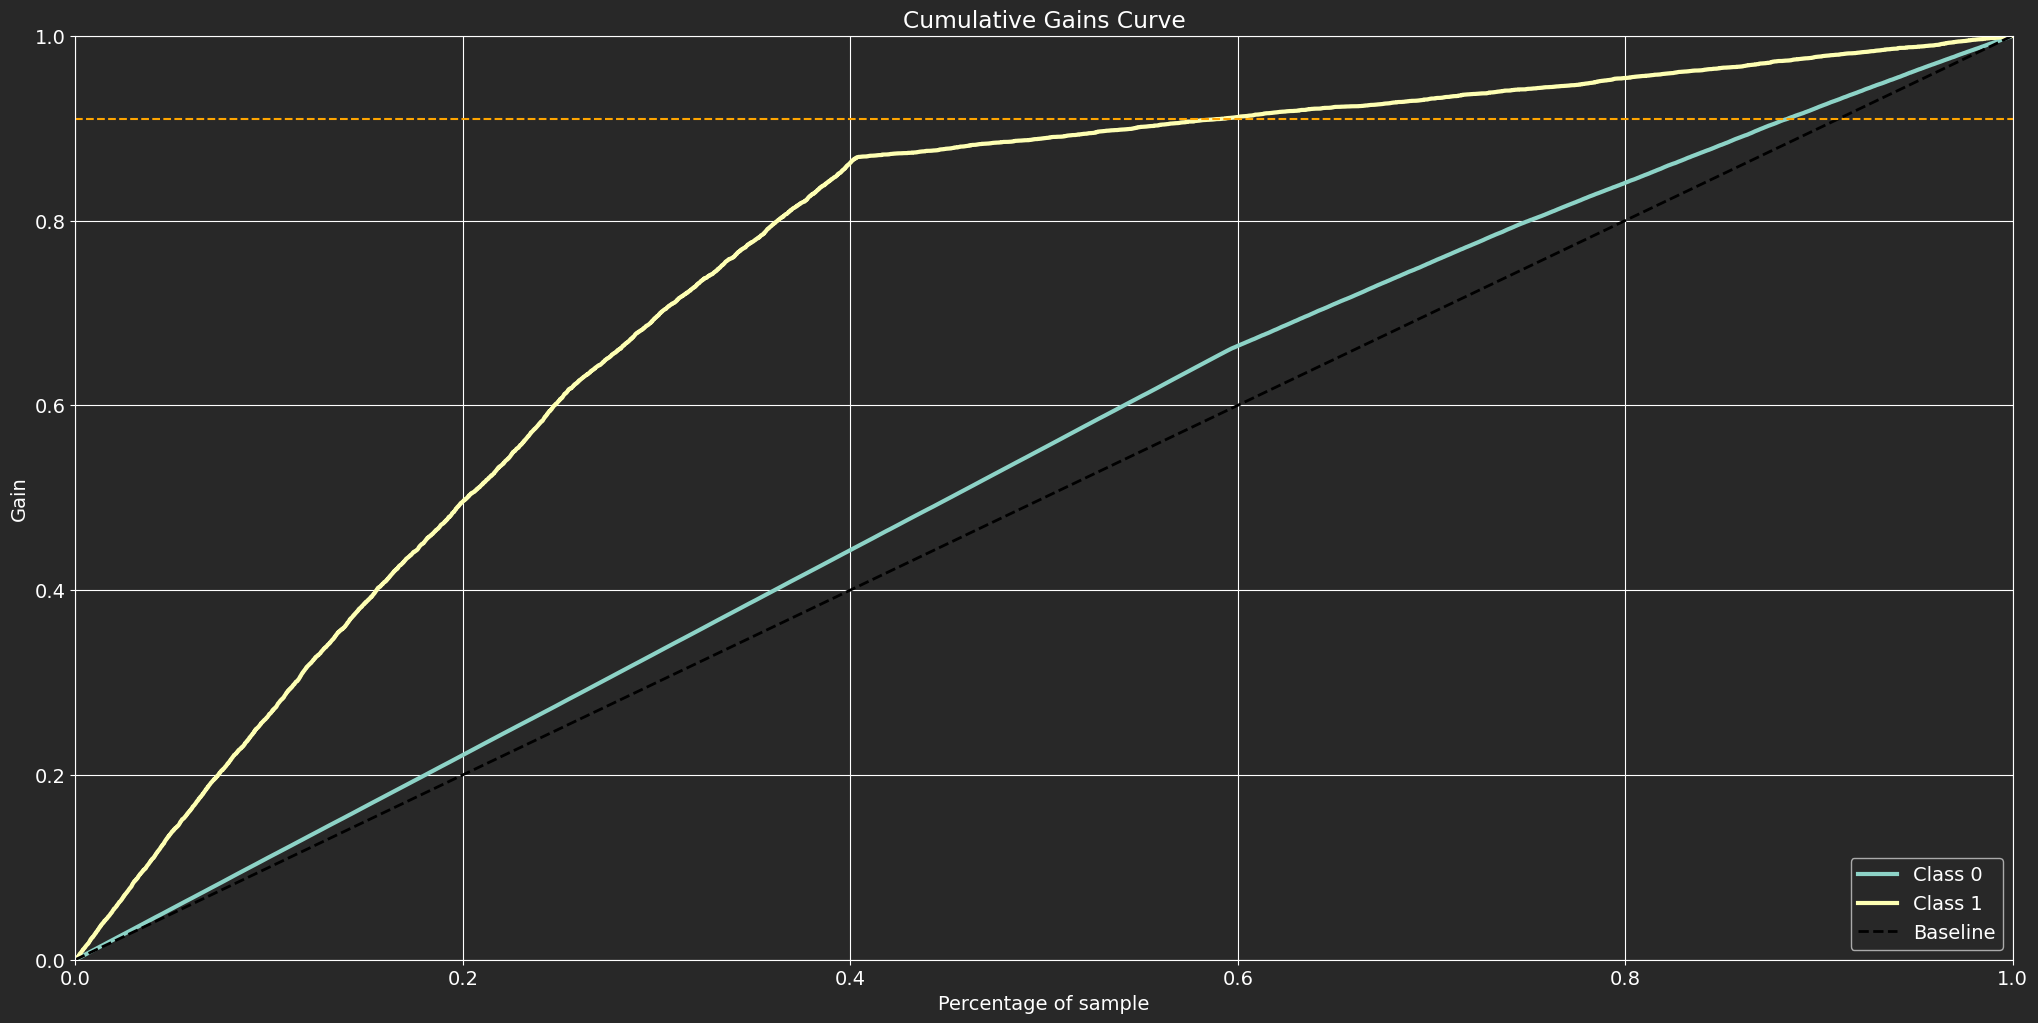

In [ ]:
# Model Definition 
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# Model Training
knn_model.fit(x_train, y_train)

# Model Predict
yhat_knn = knn_model.predict_proba(x_val)

# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);
plt.axhline(y=0.91, linestyle='--', color='orange')

# If we approach 60% of the customers in this ordened list, we can expect to reach 91% of the interested customers.

NOTE: If we approach 60% of the customers in this ordened list, we can expect to reach 91% of the interested customers.

### 7.2.1 K-Nearest Neigbors - Validation

In [ ]:
y_train.value_counts(normalize=False)

0    267485
1     37402
Name: response, dtype: int64

In [ ]:
y_validation.value_counts(normalize=False)

0    66914
1     9308
Name: response, dtype: int64

## 7.2 Logistic Regression

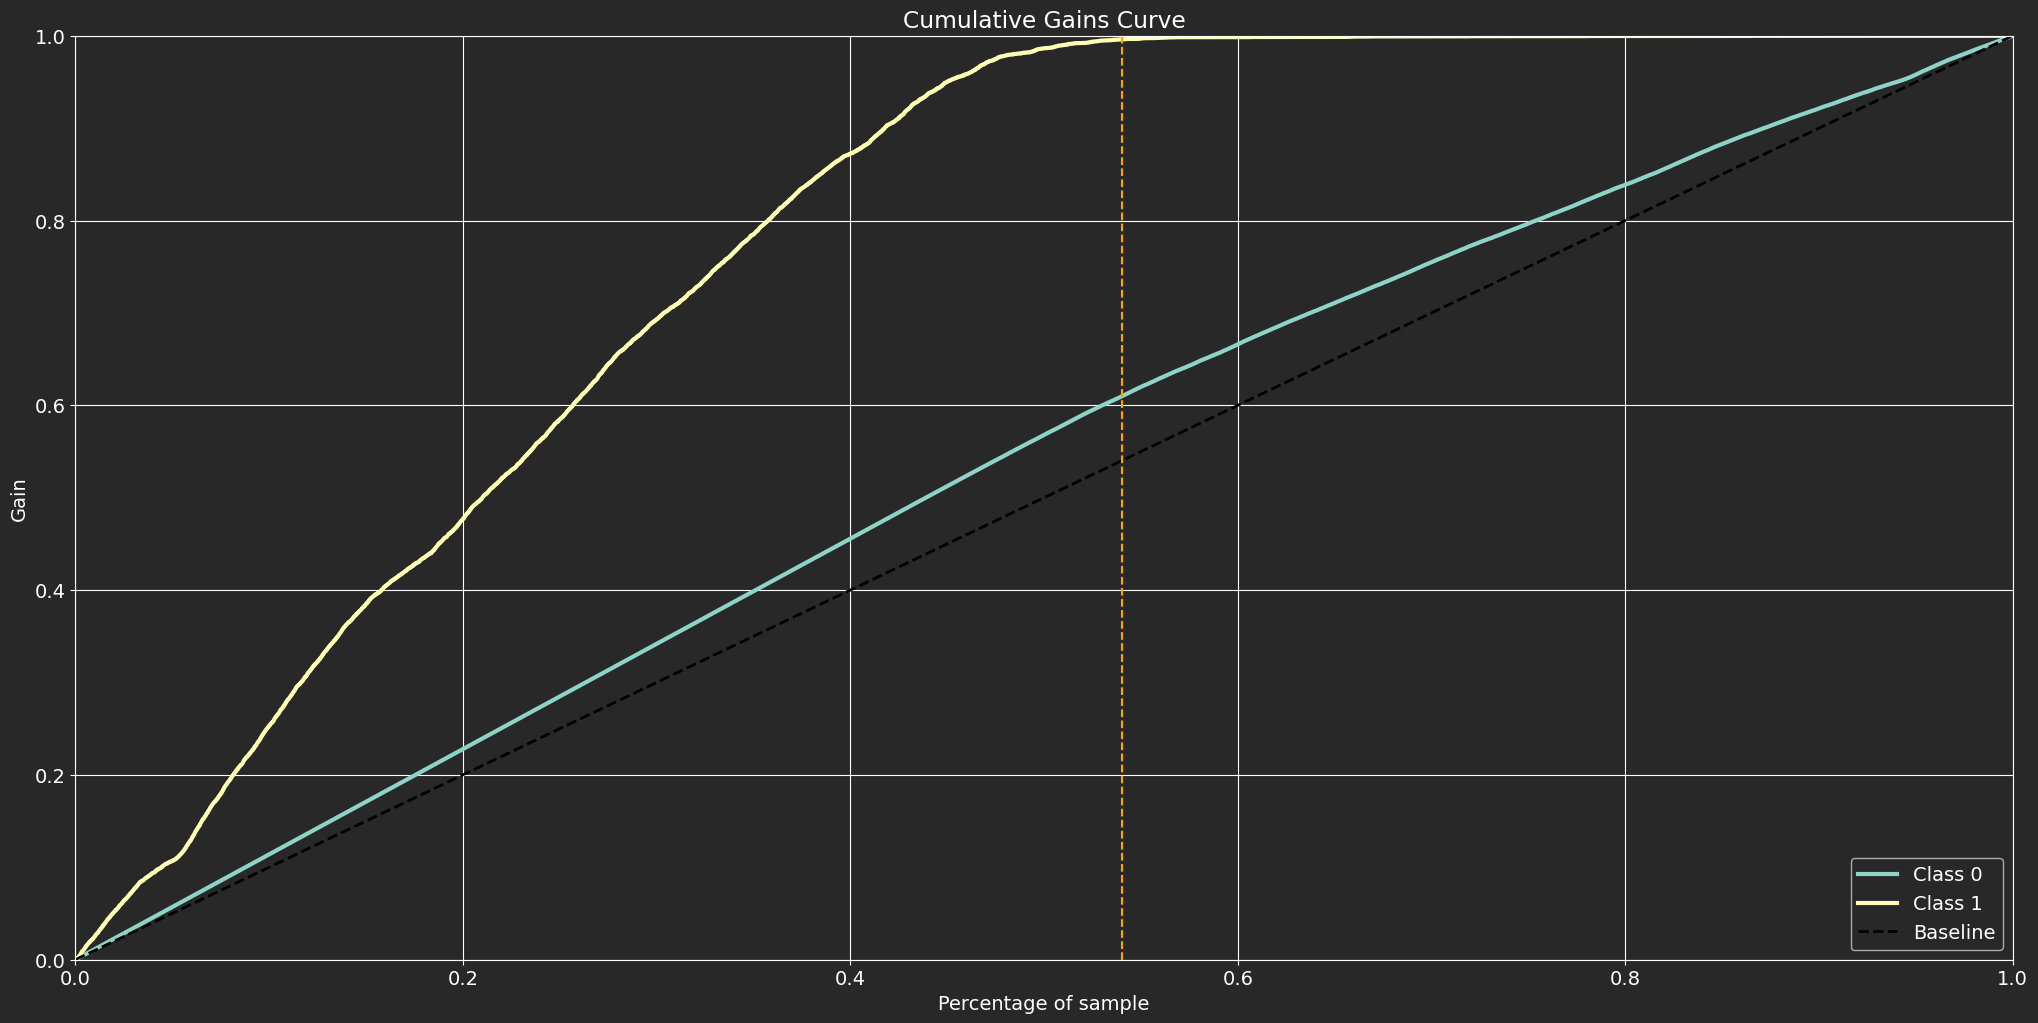

In [ ]:
# model definition
lr_model = lm.LogisticRegression(random_state=42) 

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);
plt.axvline(x=0.54, linestyle='--', color='orange')

If we approach approximately 54% of the customers in this ordened list, we can expect to reach 100% of the interested customers.

## 7.3 Extra Trees

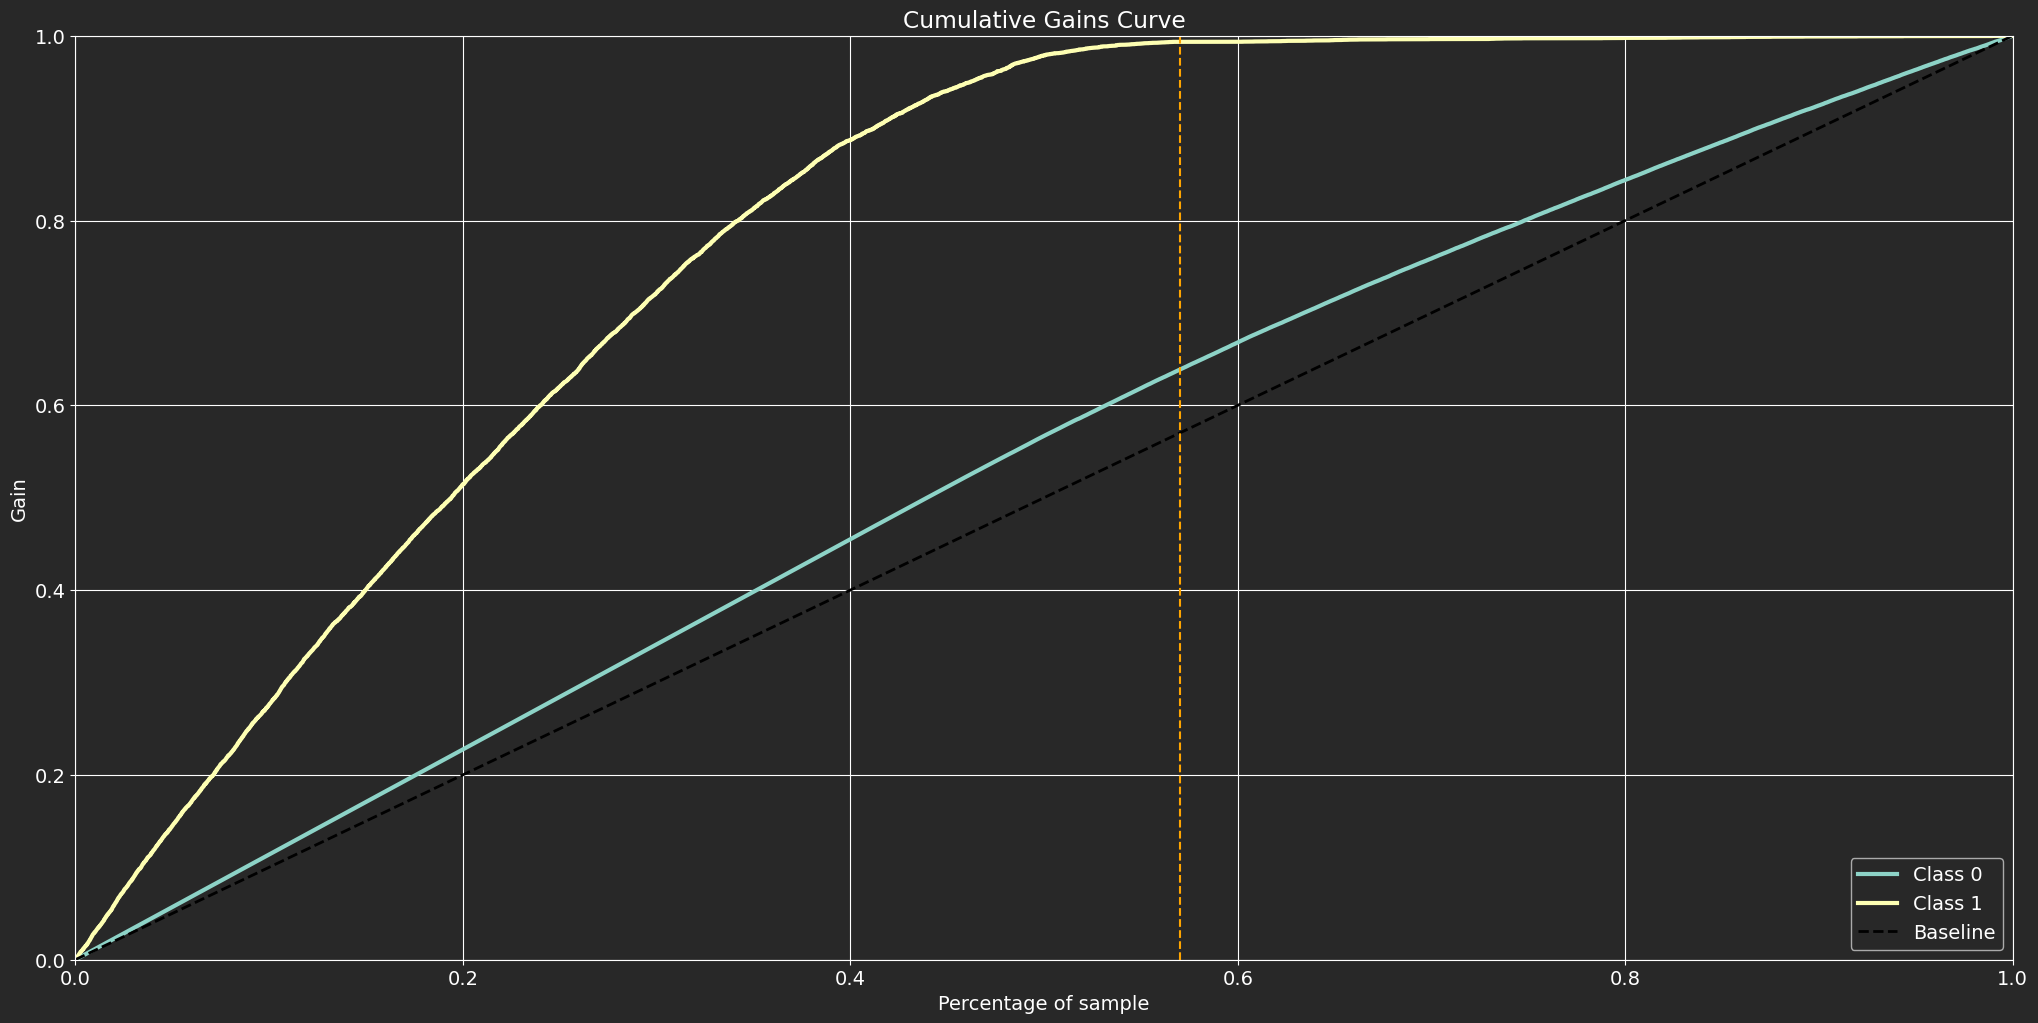

In [ ]:
# Model Definition
et = en.ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

# Model Train
et.fit(x_train, y_train)

# Model predict
yhat_et = et.predict_proba(x_val)

# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_et);
plt.axvline(x=0.57, linestyle='--', color='orange')

NOTE: If we approach approximately 57% of the customers in this ordened list, we can expect to reach 100% of the interested customers.

## 7.5 XGBoost

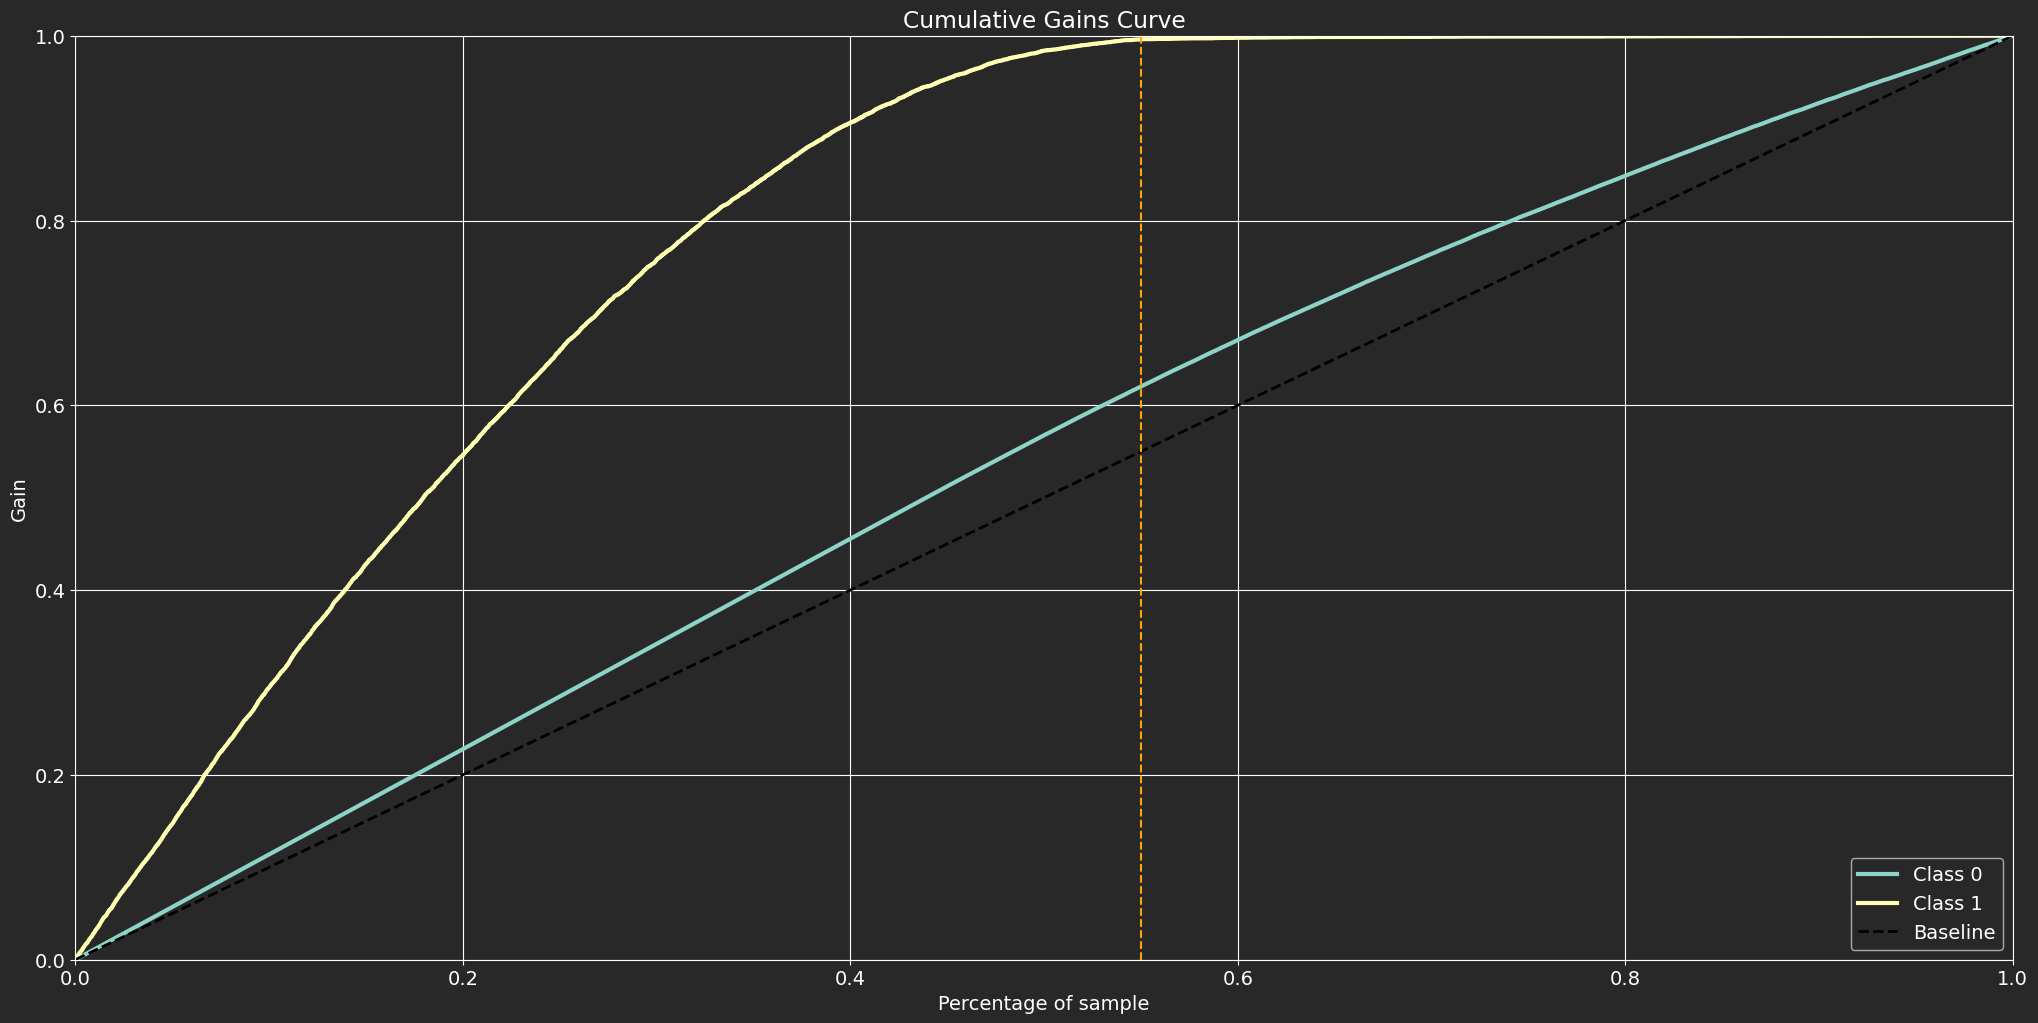

In [ ]:
# Model Definition
xgbc_model = xgbc(n_estimators=1000, n_jobs=-1, random_state=42)

# Training Model
xgbc_model.fit(x_train, y_train)

# Prediction
yhat_xgbc = xgbc_model.predict_proba(x_val)

# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgbc);
plt.axvline(x=0.55, linestyle='--', color='orange')

NOTE: If we approach approximately 55% of the customers in this ordened list, we can expect to reach 100% of the interested customers.

# 8.0 Model Performance

In [ ]:
def precision_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

In [ ]:
def recall_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

In [ ]:
0.17*y_validation.shape[0]

12957.740000000002

In [ ]:
# copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_knn[:, 1].tolist()

# sorte clients by propensity score
df8 = df8.sort_values('score', ascending=False)

# compute precision at k
precision_at_50 = precision_at_k(df8, k=50)
print('Precision at K: {}'.format(precision_at_50))

# compute precision at k
precision_at_50 = recall_at_k(df8, k=50)
print('Recall at K: {}'.format(precision_at_50*100))

df8.head(20)


Precision at K: 0.33293341331733656
Recall at K: 17.887838418564677


,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,response,score
210774,210775,0.103459,0.200000,1,0.186115,0,1,0.010916,0.015629,0.100346,1.0,0.0,0.0,0,1.000000
163407,163408,0.139021,0.246154,1,0.160584,0,1,0.049693,0.193760,0.692042,1.0,0.0,0.0,1,1.000000
310256,310257,0.103459,0.169231,1,0.122377,0,1,-1.616315,0.028020,0.083045,1.0,0.0,0.0,0,1.000000
293728,293729,0.103459,0.184615,1,0.097092,0,1,0.513798,0.193760,0.996540,1.0,0.0,0.0,0,1.000000
347235,347236,0.139021,0.492308,1,0.186115,0,1,1.074092,0.209130,0.429066,1.0,0.0,0.0,0,1.000000
162950,162951,0.103459,0.184615,1,0.122532,0,1,1.665465,0.193760,0.633218,1.0,0.0,0.0,1,1.000000
374532,374533,0.139021,0.461538,1,0.186115,0,1,0.459973,0.193760,0.380623,1.0,0.0,0.0,0,1.000000
264227,264228,0.103459,0.153846,1,0.137889,0,1,-1.616315,0.193760,0.688581,0.0,1.0,0.0,0,1.000000
129983,129984,0.139021,0.153846,1,0.186115,0,1,0.321130,0.209130,0.325260,0.0,1.0,0.0,0,1.000000
89674,89675,0.139021,0.215385,1,0.186115,0,1,-1.616315,0.193760,0.948097,1.0,0.0,0.0,1,1.000000
